

# GAN implementation

## Data generation and preprocessing

In [0]:
from collections import deque
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [0]:
# import classical libraries
%matplotlib inline
%pylab inline

# avoid warnings
import warnings
warnings.filterwarnings("ignore")

# figure size
rcParams['figure.figsize'] = (16, 9)

# print only 2 decimals
set_printoptions(precision=2)

Populating the interactive namespace from numpy and matplotlib


In [0]:
# Lorenz-63 dynamical model
def Lorenz_63(x, dx, sigma, rho, beta):
    dx = zeros((3))
    dx[0] = sigma*(x[1]-x[0])
    dx[1] = x[0]*(rho-x[2])-x[1]
    dx[2] = x[0]*x[1] - beta*x[2]
    return dx

In [0]:
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

# define the parameters
x0 = array([8,0,30]) # initial condition
dt = 0.001 # integration time step
T = 100 # number of Lorenz-63 times
sigma = 10
rho = 28
beta = 8/3

# generate the Lorenz-63 system
x = odeint(Lorenz_63, x0, arange(0.01,T,dt), args=(sigma, rho, beta))
time = arange(0.01, T, dt)
print(x.shape)

(99990, 3)


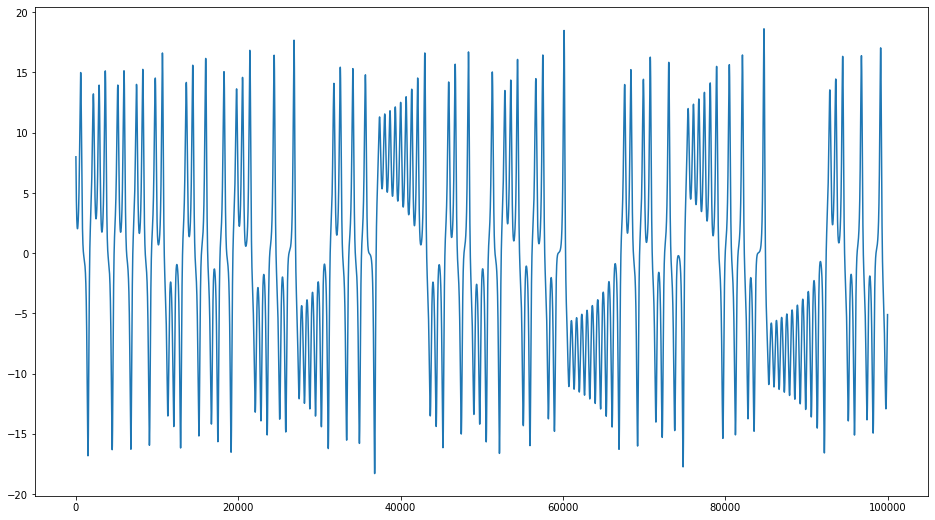

In [0]:
plt.plot(x[:,0])

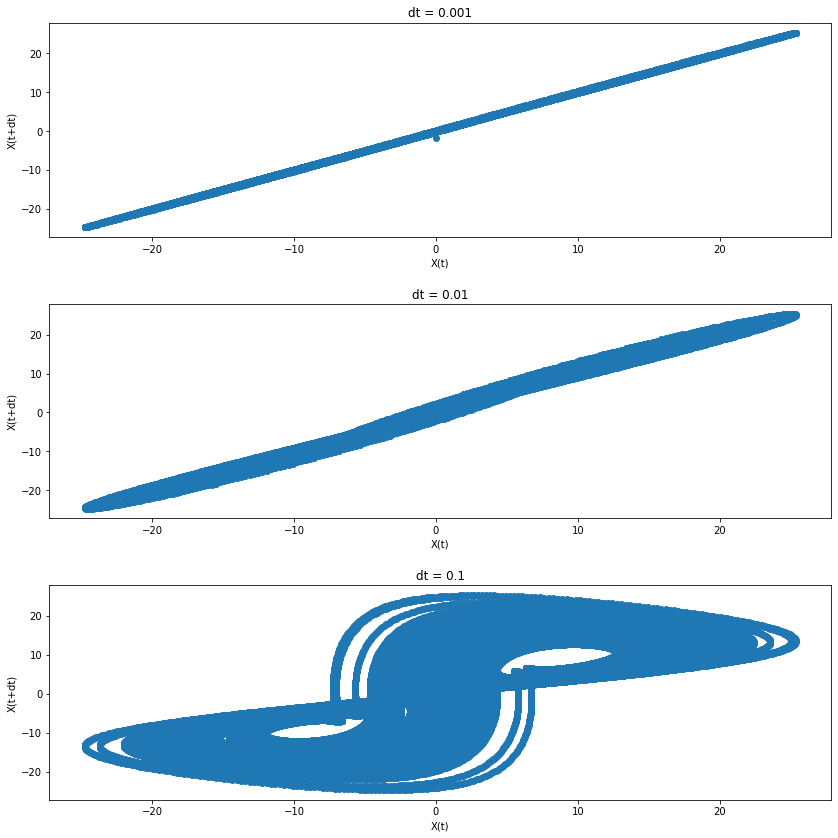

In [0]:
dt_vec = [0.001, 0.01, 0.1]

i = 1

x_ = odeint(Lorenz_63, x0, arange(0.01,T,dt), args=(sigma, rho, beta))

fig = plt.figure(figsize=(12,12))

for dt in dt_vec:
    
    xtplus = deque(x[:,1])
    xtplus.rotate(int(dt/dt_vec[0]))

    xtplus = np.array(list(xtplus))
    np.shape(xtplus)
    
    subplot(3,1,i)
    plt.scatter(x[:,1],xtplus)
    plt.title('dt = '+str(dt))
    plt.xlabel('X(t)')
    plt.ylabel('X(t+dt)')
    i += 1
    
fig.tight_layout(pad = 2)

In [0]:
def generate_data(N,l=100,T=1, dt = 0.001):
    
    #Model parameters
    #dt = 0.001 # integration time step
    sigma = 10
    rho = 28
    beta = 8/3
    #l = int((T-dt)/dt)
    
    #T = dt*(l+1)
    #dt = T/(l+1)
    
    #X = np.zeros((N,3*(l-9)))
    X = []
    for n in range(N):    

        x0 = [np.random.randn(), np.random.randn(), np.random.randn()]

        # generate the Lorenz-63 system
        x = odeint(Lorenz_63, x0, arange(0.01,T,dt), args=(sigma, rho, beta))
        #X[n,...] = np.ndarray.flatten(x)
        #X.append(np.ndarray.flatten(x))
        X.append(x.reshape(x.shape[0]*x.shape[1]))
    return np.array(X)

(1000, 3)


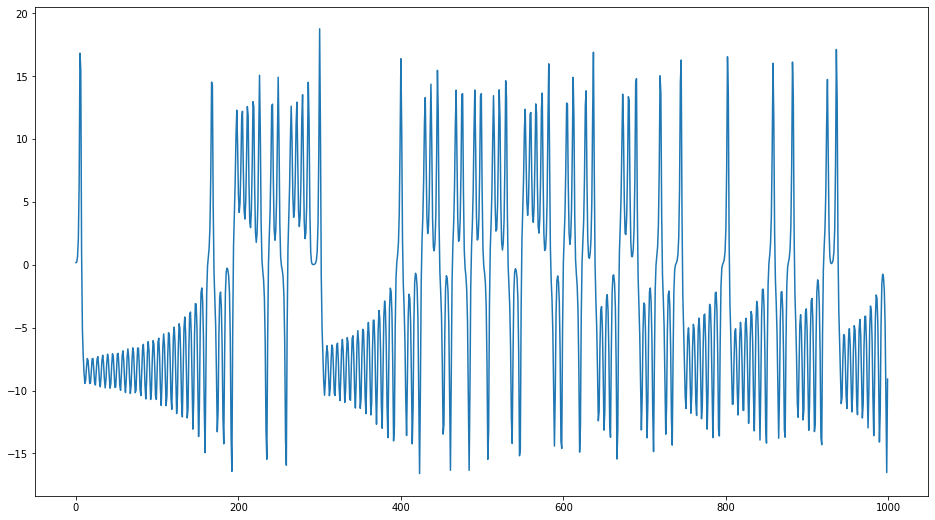

In [0]:
X = generate_data(1,T=100, dt=0.1)
X = X.reshape(int(X.shape[1]/3),3)
print(X.shape)
plt.plot(X[:,0])

In [0]:
N = 1000
X = generate_data(N,T=100, dt=0.1)

X_train, X_test = train_test_split(X, test_size=0.33, random_state=42)

In [0]:
X.shape

(1000, 3000)

## Create model

In [0]:
import keras
from keras.layers import Dense, Dropout, Input, Conv2D,LSTM, BatchNormalization
from keras.layers import LeakyReLU
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
class gan(object): 

    def __init__(self):

        self.input_dim = 3000
        self.generator = Sequential() 
        self.discriminator = Sequential()
        self.gan = Model()
        
        self.create_generator()
        self.create_discriminator()
        self.create_gan()
    
    def create_generator(self):
        
        self.generator.add(Dense(units=512,input_dim=self.input_dim,activation ='selu'))
        #self.generator.add(LeakyReLU(alpha=0.2))

        self.generator.add(Dense(units=256,activation ='selu'))
        #self.generator.add(LeakyReLU(alpha=0.2))

        self.generator.add(Dense(units=100,activation ='selu'))
        #self.generator.add(LeakyReLU(alpha=0.2))

        self.generator.add(Dense(units=self.input_dim, activation='linear'))

        #self.generator.compile(loss='binary_crossentropy', optimizer='adam')
        
    def create_discriminator(self):
        
        self.discriminator.add(BatchNormalization(input_shape=[self.input_dim]))

        self.discriminator.add(Dense(units=60, activation='selu'))

        self.discriminator.add(Dense(units=30,activation ='selu'))
        #self.discriminator.add(LeakyReLU(alpha=0.2))

        self.discriminator.add(Dense(units=10,activation ='selu'))
        #self.discriminator.add(LeakyReLU(alpha=0.2))

        self.discriminator.add(Dense(units=1, activation='sigmoid'))

        self.discriminator.compile(loss='binary_crossentropy', optimizer='adam')

    def create_gan(self):
        
        self.discriminator.trainable=False
        gan_input = Input(shape=(self.input_dim,))
        x = self.generator(gan_input)
        gan_output= self.discriminator(x)
        self.gan = Model(inputs=gan_input, outputs=gan_output)
        self.gan.compile(loss='binary_crossentropy', optimizer='adam')
    
    def gan_summary(self):
        
        self.gan.summary()
        
    def generator_summary(self):
        
        self.generator.summary()

    def discriminator_summary(self):
        
        self.discriminator.summary()
        
    def train(self,X_train, epochs=1, batch_size=128):

        #Loading the data
        batch_count = int((X_train.shape[0] / batch_size))+1

        loss_list_generator = []
        loss_list_discriminator = []
        for e in range(1,epochs+1 ):
            print("Epoch %d" %e)
            loss_generator = 0
            loss_discriminator = 0
            idx = np.random.randint(0,X_train.shape[0],X_train.shape[0])

            for _ in tqdm(range(batch_count)):

                # Real trajectories
                real_trajectory = X_train[idx[batch_size*_:batch_size*_+batch_size,...]]

                N = np.shape(real_trajectory)[0]#we now use N instead of batch_size, as the last batch
                                                #may be smaller than the batch size

                #generate  random noise as an input  to  initialize the  generator
                noise= np.random.normal(0,1, [N, self.input_dim])

                generated_trajectory = self.generator.predict(noise)#.reshape(N,100,3)

                #Construct different batches of  real and fake data 
                X= np.concatenate([real_trajectory, generated_trajectory], axis=0)

                # Labels for generated and real data
                y_dis=np.zeros(2*N)
                y_dis[:N]= 1 #0.9bat

                #Pre train discriminator on  fake and real data  before starting the gan. 
                self.discriminator.trainable=True
                
                loss_discriminator = loss_discriminator + self.discriminator.train_on_batch(X, y_dis)


                #Tricking the noised input of the Generator as real data
                noise= np.random.normal(0,1, [N, self.input_dim])
                y_gen = np.ones(N)

                # During the training of gan, 
                # the weights of discriminator should be fixed. 
                #We can enforce that by setting the trainable flag
                self.discriminator.trainable=False

                #training  the GAN by alternating the training of the Discriminator 
                #and training the chained GAN model with Discriminator’s weights freezed.
                loss_generator = loss_generator + self.gan.train_on_batch(noise, y_gen)
            loss_list_generator.append(loss_generator)
            loss_list_discriminator.append(loss_discriminator)
        return loss_list_generator, loss_list_discriminator
            #if e == 1 or e % 20 == 0:

                 #plot_generated_images(e, generator)
            
    def generate(self,N):

        noise= np.random.normal(0,1, [N, self.input_dim])

        return np.transpose(self.generator.predict(noise))
        

In [0]:
g=gan()
g.generator_summary()
g.discriminator_summary()
g.gan_summary()

RuntimeError: ignored

## Train model

In [0]:
loss_generator,loss_discriminator = g.train(X,500,128)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1


 25%|██▌       | 2/8 [00:00<00:00, 18.13it/s]

Epoch 2


 25%|██▌       | 2/8 [00:00<00:00, 19.30it/s]

Epoch 3


 25%|██▌       | 2/8 [00:00<00:00, 18.17it/s]

Epoch 4


 38%|███▊      | 3/8 [00:00<00:00, 20.28it/s]

Epoch 5


 38%|███▊      | 3/8 [00:00<00:00, 20.68it/s]

Epoch 6


 38%|███▊      | 3/8 [00:00<00:00, 20.15it/s]

Epoch 7


 25%|██▌       | 2/8 [00:00<00:00, 19.94it/s]

Epoch 8


 25%|██▌       | 2/8 [00:00<00:00, 18.69it/s]

Epoch 9


 38%|███▊      | 3/8 [00:00<00:00, 20.02it/s]

Epoch 10


 25%|██▌       | 2/8 [00:00<00:00, 19.18it/s]

Epoch 11


 25%|██▌       | 2/8 [00:00<00:00, 19.50it/s]

Epoch 12


 25%|██▌       | 2/8 [00:00<00:00, 18.47it/s]

Epoch 13


 25%|██▌       | 2/8 [00:00<00:00, 18.66it/s]

Epoch 14


 25%|██▌       | 2/8 [00:00<00:00, 19.20it/s]

Epoch 15


 25%|██▌       | 2/8 [00:00<00:00, 18.63it/s]

Epoch 16


 25%|██▌       | 2/8 [00:00<00:00, 18.36it/s]

Epoch 17


 25%|██▌       | 2/8 [00:00<00:00, 18.34it/s]

Epoch 18


 25%|██▌       | 2/8 [00:00<00:00, 19.59it/s]

Epoch 19


 25%|██▌       | 2/8 [00:00<00:00, 19.45it/s]

Epoch 20


 25%|██▌       | 2/8 [00:00<00:00, 18.84it/s]

Epoch 21


 25%|██▌       | 2/8 [00:00<00:00, 19.50it/s]

Epoch 22


 25%|██▌       | 2/8 [00:00<00:00, 19.41it/s]

Epoch 23


 38%|███▊      | 3/8 [00:00<00:00, 20.07it/s]

Epoch 24


 38%|███▊      | 3/8 [00:00<00:00, 20.61it/s]

Epoch 25


 25%|██▌       | 2/8 [00:00<00:00, 18.67it/s]

Epoch 26


 25%|██▌       | 2/8 [00:00<00:00, 19.81it/s]

Epoch 27


 25%|██▌       | 2/8 [00:00<00:00, 19.93it/s]

Epoch 28


 25%|██▌       | 2/8 [00:00<00:00, 19.64it/s]

Epoch 29


 25%|██▌       | 2/8 [00:00<00:00, 19.00it/s]

Epoch 30


 25%|██▌       | 2/8 [00:00<00:00, 18.52it/s]

Epoch 31


 25%|██▌       | 2/8 [00:00<00:00, 19.27it/s]

Epoch 32


 25%|██▌       | 2/8 [00:00<00:00, 19.25it/s]

Epoch 33


 25%|██▌       | 2/8 [00:00<00:00, 19.13it/s]

Epoch 34


 25%|██▌       | 2/8 [00:00<00:00, 19.88it/s]

Epoch 35


 25%|██▌       | 2/8 [00:00<00:00, 17.58it/s]

Epoch 36


 25%|██▌       | 2/8 [00:00<00:00, 18.37it/s]

Epoch 37


 25%|██▌       | 2/8 [00:00<00:00, 19.76it/s]

Epoch 38


 25%|██▌       | 2/8 [00:00<00:00, 18.17it/s]

Epoch 39


 25%|██▌       | 2/8 [00:00<00:00, 19.54it/s]

Epoch 40


 25%|██▌       | 2/8 [00:00<00:00, 18.80it/s]

Epoch 41


 38%|███▊      | 3/8 [00:00<00:00, 20.45it/s]

Epoch 42


 25%|██▌       | 2/8 [00:00<00:00, 18.62it/s]

Epoch 43


 25%|██▌       | 2/8 [00:00<00:00, 19.99it/s]

Epoch 44


 25%|██▌       | 2/8 [00:00<00:00, 19.78it/s]

Epoch 45


 25%|██▌       | 2/8 [00:00<00:00, 19.97it/s]

Epoch 46


 38%|███▊      | 3/8 [00:00<00:00, 20.04it/s]

Epoch 47


 25%|██▌       | 2/8 [00:00<00:00, 16.94it/s]

Epoch 48


 25%|██▌       | 2/8 [00:00<00:00, 19.56it/s]

Epoch 49


 38%|███▊      | 3/8 [00:00<00:00, 20.34it/s]

Epoch 50


 25%|██▌       | 2/8 [00:00<00:00, 19.80it/s]

Epoch 51


 25%|██▌       | 2/8 [00:00<00:00, 18.94it/s]

Epoch 52


 25%|██▌       | 2/8 [00:00<00:00, 18.04it/s]

Epoch 53


 25%|██▌       | 2/8 [00:00<00:00, 19.29it/s]

Epoch 54


 25%|██▌       | 2/8 [00:00<00:00, 19.64it/s]

Epoch 55


 25%|██▌       | 2/8 [00:00<00:00, 19.77it/s]

Epoch 56


 38%|███▊      | 3/8 [00:00<00:00, 19.78it/s]

Epoch 57


 25%|██▌       | 2/8 [00:00<00:00, 19.43it/s]

Epoch 58


 25%|██▌       | 2/8 [00:00<00:00, 18.47it/s]

Epoch 59


 25%|██▌       | 2/8 [00:00<00:00, 16.94it/s]

Epoch 60


 25%|██▌       | 2/8 [00:00<00:00, 19.72it/s]

Epoch 61


 25%|██▌       | 2/8 [00:00<00:00, 18.96it/s]

Epoch 62


 25%|██▌       | 2/8 [00:00<00:00, 17.88it/s]

Epoch 63


 38%|███▊      | 3/8 [00:00<00:00, 20.30it/s]

Epoch 64


 25%|██▌       | 2/8 [00:00<00:00, 17.82it/s]

Epoch 65


 25%|██▌       | 2/8 [00:00<00:00, 19.22it/s]

Epoch 66


 25%|██▌       | 2/8 [00:00<00:00, 19.64it/s]

Epoch 67


 25%|██▌       | 2/8 [00:00<00:00, 19.90it/s]

Epoch 68


 25%|██▌       | 2/8 [00:00<00:00, 19.35it/s]

Epoch 69


 25%|██▌       | 2/8 [00:00<00:00, 18.04it/s]

Epoch 70


 25%|██▌       | 2/8 [00:00<00:00, 19.59it/s]

Epoch 71


 25%|██▌       | 2/8 [00:00<00:00, 19.14it/s]

Epoch 72


 25%|██▌       | 2/8 [00:00<00:00, 18.62it/s]

Epoch 73


 25%|██▌       | 2/8 [00:00<00:00, 19.62it/s]

Epoch 74


 25%|██▌       | 2/8 [00:00<00:00, 19.24it/s]

Epoch 75


 25%|██▌       | 2/8 [00:00<00:00, 19.33it/s]

Epoch 76


 25%|██▌       | 2/8 [00:00<00:00, 18.86it/s]

Epoch 77


 25%|██▌       | 2/8 [00:00<00:00, 19.11it/s]

Epoch 78


 38%|███▊      | 3/8 [00:00<00:00, 20.23it/s]

Epoch 79


 25%|██▌       | 2/8 [00:00<00:00, 19.67it/s]

Epoch 80


 25%|██▌       | 2/8 [00:00<00:00, 19.29it/s]

Epoch 81


 25%|██▌       | 2/8 [00:00<00:00, 18.08it/s]

Epoch 82


 25%|██▌       | 2/8 [00:00<00:00, 19.49it/s]

Epoch 83


 25%|██▌       | 2/8 [00:00<00:00, 18.99it/s]

Epoch 84


 25%|██▌       | 2/8 [00:00<00:00, 19.48it/s]

Epoch 85


 25%|██▌       | 2/8 [00:00<00:00, 19.94it/s]

Epoch 86


 25%|██▌       | 2/8 [00:00<00:00, 17.17it/s]

Epoch 87


 25%|██▌       | 2/8 [00:00<00:00, 19.33it/s]

Epoch 88


 25%|██▌       | 2/8 [00:00<00:00, 19.32it/s]

Epoch 89


 25%|██▌       | 2/8 [00:00<00:00, 19.25it/s]

Epoch 90


 25%|██▌       | 2/8 [00:00<00:00, 19.89it/s]

Epoch 91


 25%|██▌       | 2/8 [00:00<00:00, 17.71it/s]

Epoch 92


 38%|███▊      | 3/8 [00:00<00:00, 20.21it/s]

Epoch 93


 25%|██▌       | 2/8 [00:00<00:00, 18.99it/s]

Epoch 94


 25%|██▌       | 2/8 [00:00<00:00, 19.26it/s]

Epoch 95


 25%|██▌       | 2/8 [00:00<00:00, 19.19it/s]

Epoch 96


 25%|██▌       | 2/8 [00:00<00:00, 17.08it/s]

Epoch 97


 25%|██▌       | 2/8 [00:00<00:00, 18.27it/s]

Epoch 98


 25%|██▌       | 2/8 [00:00<00:00, 19.14it/s]

Epoch 99


 25%|██▌       | 2/8 [00:00<00:00, 19.14it/s]

Epoch 100


 25%|██▌       | 2/8 [00:00<00:00, 19.32it/s]

Epoch 101


 25%|██▌       | 2/8 [00:00<00:00, 19.13it/s]

Epoch 102


 25%|██▌       | 2/8 [00:00<00:00, 19.36it/s]

Epoch 103


 25%|██▌       | 2/8 [00:00<00:00, 17.24it/s]

Epoch 104


 25%|██▌       | 2/8 [00:00<00:00, 18.45it/s]

Epoch 105


 25%|██▌       | 2/8 [00:00<00:00, 19.78it/s]

Epoch 106


 25%|██▌       | 2/8 [00:00<00:00, 19.54it/s]

Epoch 107


 38%|███▊      | 3/8 [00:00<00:00, 20.08it/s]

Epoch 108


 38%|███▊      | 3/8 [00:00<00:00, 20.30it/s]

Epoch 109


 25%|██▌       | 2/8 [00:00<00:00, 19.70it/s]

Epoch 110


 25%|██▌       | 2/8 [00:00<00:00, 19.48it/s]

Epoch 111


 25%|██▌       | 2/8 [00:00<00:00, 19.94it/s]

Epoch 112


 25%|██▌       | 2/8 [00:00<00:00, 19.23it/s]

Epoch 113


 25%|██▌       | 2/8 [00:00<00:00, 19.66it/s]

Epoch 114


 25%|██▌       | 2/8 [00:00<00:00, 19.97it/s]

Epoch 115


 25%|██▌       | 2/8 [00:00<00:00, 19.73it/s]

Epoch 116


 25%|██▌       | 2/8 [00:00<00:00, 19.54it/s]

Epoch 117


 25%|██▌       | 2/8 [00:00<00:00, 19.34it/s]

Epoch 118


 25%|██▌       | 2/8 [00:00<00:00, 19.01it/s]

Epoch 119


 25%|██▌       | 2/8 [00:00<00:00, 19.80it/s]

Epoch 120


 25%|██▌       | 2/8 [00:00<00:00, 18.02it/s]

Epoch 121


 25%|██▌       | 2/8 [00:00<00:00, 18.66it/s]

Epoch 122


 25%|██▌       | 2/8 [00:00<00:00, 18.90it/s]

Epoch 123


 38%|███▊      | 3/8 [00:00<00:00, 20.89it/s]

Epoch 124


 25%|██▌       | 2/8 [00:00<00:00, 18.70it/s]

Epoch 125


 25%|██▌       | 2/8 [00:00<00:00, 17.53it/s]

Epoch 126


 25%|██▌       | 2/8 [00:00<00:00, 19.27it/s]

Epoch 127


 38%|███▊      | 3/8 [00:00<00:00, 20.28it/s]

Epoch 128


 25%|██▌       | 2/8 [00:00<00:00, 19.03it/s]

Epoch 129


 25%|██▌       | 2/8 [00:00<00:00, 19.00it/s]

Epoch 130


 25%|██▌       | 2/8 [00:00<00:00, 19.04it/s]

Epoch 131


 25%|██▌       | 2/8 [00:00<00:00, 18.91it/s]

Epoch 132


 25%|██▌       | 2/8 [00:00<00:00, 18.08it/s]

Epoch 133


 25%|██▌       | 2/8 [00:00<00:00, 19.76it/s]

Epoch 134


 25%|██▌       | 2/8 [00:00<00:00, 19.59it/s]

Epoch 135


 25%|██▌       | 2/8 [00:00<00:00, 19.93it/s]

Epoch 136


 25%|██▌       | 2/8 [00:00<00:00, 19.33it/s]

Epoch 137


 25%|██▌       | 2/8 [00:00<00:00, 19.06it/s]

Epoch 138


 25%|██▌       | 2/8 [00:00<00:00, 19.48it/s]

Epoch 139


 25%|██▌       | 2/8 [00:00<00:00, 19.41it/s]

Epoch 140


 25%|██▌       | 2/8 [00:00<00:00, 19.22it/s]

Epoch 141


 25%|██▌       | 2/8 [00:00<00:00, 18.31it/s]

Epoch 142


 25%|██▌       | 2/8 [00:00<00:00, 19.24it/s]

Epoch 143


 25%|██▌       | 2/8 [00:00<00:00, 19.09it/s]

Epoch 144


 25%|██▌       | 2/8 [00:00<00:00, 17.87it/s]

Epoch 145


 25%|██▌       | 2/8 [00:00<00:00, 18.58it/s]

Epoch 146


 25%|██▌       | 2/8 [00:00<00:00, 18.72it/s]

Epoch 147


 25%|██▌       | 2/8 [00:00<00:00, 18.50it/s]

Epoch 148


 25%|██▌       | 2/8 [00:00<00:00, 19.01it/s]

Epoch 149


 25%|██▌       | 2/8 [00:00<00:00, 18.59it/s]

Epoch 150


 25%|██▌       | 2/8 [00:00<00:00, 18.92it/s]

Epoch 151


 25%|██▌       | 2/8 [00:00<00:00, 19.23it/s]

Epoch 152


 25%|██▌       | 2/8 [00:00<00:00, 19.10it/s]

Epoch 153


 25%|██▌       | 2/8 [00:00<00:00, 19.34it/s]

Epoch 154


 25%|██▌       | 2/8 [00:00<00:00, 18.60it/s]

Epoch 155


 25%|██▌       | 2/8 [00:00<00:00, 18.81it/s]

Epoch 156


 25%|██▌       | 2/8 [00:00<00:00, 17.67it/s]

Epoch 157


 25%|██▌       | 2/8 [00:00<00:00, 19.95it/s]

Epoch 158


 25%|██▌       | 2/8 [00:00<00:00, 19.77it/s]

Epoch 159


 25%|██▌       | 2/8 [00:00<00:00, 19.48it/s]

Epoch 160


 25%|██▌       | 2/8 [00:00<00:00, 19.71it/s]

Epoch 161


 25%|██▌       | 2/8 [00:00<00:00, 18.30it/s]

Epoch 162


 25%|██▌       | 2/8 [00:00<00:00, 19.58it/s]

Epoch 163


 25%|██▌       | 2/8 [00:00<00:00, 18.90it/s]

Epoch 164


 25%|██▌       | 2/8 [00:00<00:00, 17.76it/s]

Epoch 165


 25%|██▌       | 2/8 [00:00<00:00, 17.83it/s]

Epoch 166


 25%|██▌       | 2/8 [00:00<00:00, 17.25it/s]

Epoch 167


 25%|██▌       | 2/8 [00:00<00:00, 18.90it/s]

Epoch 168


 25%|██▌       | 2/8 [00:00<00:00, 18.38it/s]

Epoch 169


 25%|██▌       | 2/8 [00:00<00:00, 18.92it/s]

Epoch 170


 25%|██▌       | 2/8 [00:00<00:00, 19.18it/s]

Epoch 171


 25%|██▌       | 2/8 [00:00<00:00, 19.34it/s]

Epoch 172


 25%|██▌       | 2/8 [00:00<00:00, 19.51it/s]

Epoch 173


 25%|██▌       | 2/8 [00:00<00:00, 17.91it/s]

Epoch 174


 25%|██▌       | 2/8 [00:00<00:00, 19.36it/s]

Epoch 175


 25%|██▌       | 2/8 [00:00<00:00, 18.93it/s]

Epoch 176


 25%|██▌       | 2/8 [00:00<00:00, 19.63it/s]

Epoch 177


 25%|██▌       | 2/8 [00:00<00:00, 18.78it/s]

Epoch 178


 25%|██▌       | 2/8 [00:00<00:00, 19.40it/s]

Epoch 179


 25%|██▌       | 2/8 [00:00<00:00, 18.66it/s]

Epoch 180


 25%|██▌       | 2/8 [00:00<00:00, 18.69it/s]

Epoch 181


 25%|██▌       | 2/8 [00:00<00:00, 19.26it/s]

Epoch 182


 25%|██▌       | 2/8 [00:00<00:00, 19.93it/s]

Epoch 183


 25%|██▌       | 2/8 [00:00<00:00, 19.07it/s]

Epoch 184


 25%|██▌       | 2/8 [00:00<00:00, 19.08it/s]

Epoch 185


 25%|██▌       | 2/8 [00:00<00:00, 18.63it/s]

Epoch 186


 25%|██▌       | 2/8 [00:00<00:00, 19.96it/s]

Epoch 187


 25%|██▌       | 2/8 [00:00<00:00, 18.83it/s]

Epoch 188


 25%|██▌       | 2/8 [00:00<00:00, 18.14it/s]

Epoch 189


 25%|██▌       | 2/8 [00:00<00:00, 19.69it/s]

Epoch 190


 25%|██▌       | 2/8 [00:00<00:00, 18.71it/s]

Epoch 191


 25%|██▌       | 2/8 [00:00<00:00, 18.53it/s]

Epoch 192


 25%|██▌       | 2/8 [00:00<00:00, 17.65it/s]

Epoch 193


 25%|██▌       | 2/8 [00:00<00:00, 18.03it/s]

Epoch 194


 25%|██▌       | 2/8 [00:00<00:00, 18.94it/s]

Epoch 195


 25%|██▌       | 2/8 [00:00<00:00, 19.08it/s]

Epoch 196


 25%|██▌       | 2/8 [00:00<00:00, 18.84it/s]

Epoch 197


 25%|██▌       | 2/8 [00:00<00:00, 18.45it/s]

Epoch 198


 25%|██▌       | 2/8 [00:00<00:00, 19.50it/s]

Epoch 199


 25%|██▌       | 2/8 [00:00<00:00, 19.78it/s]

Epoch 200


 25%|██▌       | 2/8 [00:00<00:00, 19.06it/s]

Epoch 201


 38%|███▊      | 3/8 [00:00<00:00, 19.66it/s]

Epoch 202


 25%|██▌       | 2/8 [00:00<00:00, 19.70it/s]

Epoch 203


 25%|██▌       | 2/8 [00:00<00:00, 18.82it/s]

Epoch 204


 25%|██▌       | 2/8 [00:00<00:00, 17.77it/s]

Epoch 205


 25%|██▌       | 2/8 [00:00<00:00, 19.40it/s]

Epoch 206


 25%|██▌       | 2/8 [00:00<00:00, 17.23it/s]

Epoch 207


 25%|██▌       | 2/8 [00:00<00:00, 18.71it/s]

Epoch 208


 25%|██▌       | 2/8 [00:00<00:00, 18.48it/s]

Epoch 209


 25%|██▌       | 2/8 [00:00<00:00, 19.03it/s]

Epoch 210


 25%|██▌       | 2/8 [00:00<00:00, 19.90it/s]

Epoch 211


 38%|███▊      | 3/8 [00:00<00:00, 19.20it/s]

Epoch 212


 38%|███▊      | 3/8 [00:00<00:00, 19.20it/s]

Epoch 213


 25%|██▌       | 2/8 [00:00<00:00, 19.90it/s]

Epoch 214


 38%|███▊      | 3/8 [00:00<00:00, 20.50it/s]

Epoch 215


 25%|██▌       | 2/8 [00:00<00:00, 19.13it/s]

Epoch 216


 25%|██▌       | 2/8 [00:00<00:00, 17.17it/s]

Epoch 217


 25%|██▌       | 2/8 [00:00<00:00, 19.14it/s]

Epoch 218


 38%|███▊      | 3/8 [00:00<00:00, 20.26it/s]

Epoch 219


 25%|██▌       | 2/8 [00:00<00:00, 17.99it/s]

Epoch 220


 25%|██▌       | 2/8 [00:00<00:00, 18.96it/s]

Epoch 221


 25%|██▌       | 2/8 [00:00<00:00, 17.99it/s]

Epoch 222


 25%|██▌       | 2/8 [00:00<00:00, 19.92it/s]

Epoch 223


 25%|██▌       | 2/8 [00:00<00:00, 18.88it/s]

Epoch 224


 25%|██▌       | 2/8 [00:00<00:00, 18.86it/s]

Epoch 225


 25%|██▌       | 2/8 [00:00<00:00, 19.58it/s]

Epoch 226


 38%|███▊      | 3/8 [00:00<00:00, 20.35it/s]

Epoch 227


 25%|██▌       | 2/8 [00:00<00:00, 18.61it/s]

Epoch 228


 25%|██▌       | 2/8 [00:00<00:00, 19.43it/s]

Epoch 229


 25%|██▌       | 2/8 [00:00<00:00, 19.29it/s]

Epoch 230


 25%|██▌       | 2/8 [00:00<00:00, 19.15it/s]

Epoch 231


 25%|██▌       | 2/8 [00:00<00:00, 19.21it/s]

Epoch 232


 25%|██▌       | 2/8 [00:00<00:00, 19.33it/s]

Epoch 233


 25%|██▌       | 2/8 [00:00<00:00, 18.99it/s]

Epoch 234


 25%|██▌       | 2/8 [00:00<00:00, 19.77it/s]

Epoch 235


 25%|██▌       | 2/8 [00:00<00:00, 19.28it/s]

Epoch 236


 25%|██▌       | 2/8 [00:00<00:00, 19.59it/s]

Epoch 237


 38%|███▊      | 3/8 [00:00<00:00, 20.47it/s]

Epoch 238


 25%|██▌       | 2/8 [00:00<00:00, 19.01it/s]

Epoch 239


 25%|██▌       | 2/8 [00:00<00:00, 19.21it/s]

Epoch 240


 25%|██▌       | 2/8 [00:00<00:00, 19.62it/s]

Epoch 241


 25%|██▌       | 2/8 [00:00<00:00, 17.40it/s]

Epoch 242


 25%|██▌       | 2/8 [00:00<00:00, 18.15it/s]

Epoch 243


 25%|██▌       | 2/8 [00:00<00:00, 17.84it/s]

Epoch 244


 25%|██▌       | 2/8 [00:00<00:00, 19.56it/s]

Epoch 245


 25%|██▌       | 2/8 [00:00<00:00, 19.64it/s]

Epoch 246


 25%|██▌       | 2/8 [00:00<00:00, 18.81it/s]

Epoch 247


 25%|██▌       | 2/8 [00:00<00:00, 18.43it/s]

Epoch 248


 25%|██▌       | 2/8 [00:00<00:00, 19.00it/s]

Epoch 249


 25%|██▌       | 2/8 [00:00<00:00, 18.66it/s]

Epoch 250


 25%|██▌       | 2/8 [00:00<00:00, 19.38it/s]

Epoch 251


 25%|██▌       | 2/8 [00:00<00:00, 18.46it/s]

Epoch 252


 38%|███▊      | 3/8 [00:00<00:00, 19.60it/s]

Epoch 253


 25%|██▌       | 2/8 [00:00<00:00, 19.19it/s]

Epoch 254


 25%|██▌       | 2/8 [00:00<00:00, 19.38it/s]

Epoch 255


 25%|██▌       | 2/8 [00:00<00:00, 17.52it/s]

Epoch 256


 25%|██▌       | 2/8 [00:00<00:00, 19.74it/s]

Epoch 257


 25%|██▌       | 2/8 [00:00<00:00, 18.98it/s]

Epoch 258


 25%|██▌       | 2/8 [00:00<00:00, 19.82it/s]

Epoch 259


 38%|███▊      | 3/8 [00:00<00:00, 20.20it/s]

Epoch 260


 25%|██▌       | 2/8 [00:00<00:00, 18.96it/s]

Epoch 261


 25%|██▌       | 2/8 [00:00<00:00, 18.86it/s]

Epoch 262


 25%|██▌       | 2/8 [00:00<00:00, 19.65it/s]

Epoch 263


 25%|██▌       | 2/8 [00:00<00:00, 19.30it/s]

Epoch 264


 25%|██▌       | 2/8 [00:00<00:00, 19.68it/s]

Epoch 265


 25%|██▌       | 2/8 [00:00<00:00, 18.78it/s]

Epoch 266


 38%|███▊      | 3/8 [00:00<00:00, 20.52it/s]

Epoch 267


 25%|██▌       | 2/8 [00:00<00:00, 17.70it/s]

Epoch 268


 25%|██▌       | 2/8 [00:00<00:00, 17.96it/s]

Epoch 269


 25%|██▌       | 2/8 [00:00<00:00, 18.11it/s]

Epoch 270


 25%|██▌       | 2/8 [00:00<00:00, 19.47it/s]

Epoch 271


 25%|██▌       | 2/8 [00:00<00:00, 19.94it/s]

Epoch 272


 25%|██▌       | 2/8 [00:00<00:00, 18.56it/s]

Epoch 273


 25%|██▌       | 2/8 [00:00<00:00, 19.45it/s]

Epoch 274


 25%|██▌       | 2/8 [00:00<00:00, 19.45it/s]

Epoch 275


 25%|██▌       | 2/8 [00:00<00:00, 19.64it/s]

Epoch 276


 25%|██▌       | 2/8 [00:00<00:00, 19.65it/s]

Epoch 277


 25%|██▌       | 2/8 [00:00<00:00, 19.29it/s]

Epoch 278


 38%|███▊      | 3/8 [00:00<00:00, 19.95it/s]

Epoch 279


 25%|██▌       | 2/8 [00:00<00:00, 19.57it/s]

Epoch 280


 38%|███▊      | 3/8 [00:00<00:00, 20.46it/s]

Epoch 281


 25%|██▌       | 2/8 [00:00<00:00, 19.55it/s]

Epoch 282


 25%|██▌       | 2/8 [00:00<00:00, 18.69it/s]

Epoch 283


 25%|██▌       | 2/8 [00:00<00:00, 19.50it/s]

Epoch 284


 25%|██▌       | 2/8 [00:00<00:00, 19.05it/s]

Epoch 285


 25%|██▌       | 2/8 [00:00<00:00, 19.34it/s]

Epoch 286


 25%|██▌       | 2/8 [00:00<00:00, 19.73it/s]

Epoch 287


 38%|███▊      | 3/8 [00:00<00:00, 20.28it/s]

Epoch 288


 25%|██▌       | 2/8 [00:00<00:00, 18.63it/s]

Epoch 289


 25%|██▌       | 2/8 [00:00<00:00, 19.75it/s]

Epoch 290


 25%|██▌       | 2/8 [00:00<00:00, 17.41it/s]

Epoch 291


 38%|███▊      | 3/8 [00:00<00:00, 20.08it/s]

Epoch 292


 25%|██▌       | 2/8 [00:00<00:00, 18.88it/s]

Epoch 293


 38%|███▊      | 3/8 [00:00<00:00, 20.41it/s]

Epoch 294


 25%|██▌       | 2/8 [00:00<00:00, 17.48it/s]

Epoch 295


 25%|██▌       | 2/8 [00:00<00:00, 18.91it/s]

Epoch 296


 25%|██▌       | 2/8 [00:00<00:00, 19.62it/s]

Epoch 297


 25%|██▌       | 2/8 [00:00<00:00, 18.38it/s]

Epoch 298


 25%|██▌       | 2/8 [00:00<00:00, 18.48it/s]

Epoch 299


 25%|██▌       | 2/8 [00:00<00:00, 17.94it/s]

Epoch 300


 25%|██▌       | 2/8 [00:00<00:00, 19.80it/s]

Epoch 301


 25%|██▌       | 2/8 [00:00<00:00, 19.53it/s]

Epoch 302


 38%|███▊      | 3/8 [00:00<00:00, 20.11it/s]

Epoch 303


 25%|██▌       | 2/8 [00:00<00:00, 19.45it/s]

Epoch 304


 25%|██▌       | 2/8 [00:00<00:00, 18.22it/s]

Epoch 305


 25%|██▌       | 2/8 [00:00<00:00, 19.51it/s]

Epoch 306


 25%|██▌       | 2/8 [00:00<00:00, 19.03it/s]

Epoch 307


 25%|██▌       | 2/8 [00:00<00:00, 18.62it/s]

Epoch 308


 25%|██▌       | 2/8 [00:00<00:00, 19.68it/s]

Epoch 309


 25%|██▌       | 2/8 [00:00<00:00, 19.43it/s]

Epoch 310


 38%|███▊      | 3/8 [00:00<00:00, 19.77it/s]

Epoch 311


 25%|██▌       | 2/8 [00:00<00:00, 19.66it/s]

Epoch 312


 38%|███▊      | 3/8 [00:00<00:00, 20.02it/s]

Epoch 313


 25%|██▌       | 2/8 [00:00<00:00, 19.97it/s]

Epoch 314


 25%|██▌       | 2/8 [00:00<00:00, 19.28it/s]

Epoch 315


 25%|██▌       | 2/8 [00:00<00:00, 19.43it/s]

Epoch 316


 25%|██▌       | 2/8 [00:00<00:00, 18.36it/s]

Epoch 317


 25%|██▌       | 2/8 [00:00<00:00, 18.95it/s]

Epoch 318


 25%|██▌       | 2/8 [00:00<00:00, 18.66it/s]

Epoch 319


 25%|██▌       | 2/8 [00:00<00:00, 18.65it/s]

Epoch 320


 25%|██▌       | 2/8 [00:00<00:00, 18.94it/s]

Epoch 321


 25%|██▌       | 2/8 [00:00<00:00, 18.58it/s]

Epoch 322


 25%|██▌       | 2/8 [00:00<00:00, 18.69it/s]

Epoch 323


 25%|██▌       | 2/8 [00:00<00:00, 19.59it/s]

Epoch 324


 25%|██▌       | 2/8 [00:00<00:00, 19.43it/s]

Epoch 325


 25%|██▌       | 2/8 [00:00<00:00, 17.60it/s]

Epoch 326


 25%|██▌       | 2/8 [00:00<00:00, 19.44it/s]

Epoch 327


 25%|██▌       | 2/8 [00:00<00:00, 19.03it/s]

Epoch 328


 25%|██▌       | 2/8 [00:00<00:00, 18.62it/s]

Epoch 329


 25%|██▌       | 2/8 [00:00<00:00, 18.63it/s]

Epoch 330


 25%|██▌       | 2/8 [00:00<00:00, 19.22it/s]

Epoch 331


 25%|██▌       | 2/8 [00:00<00:00, 18.59it/s]

Epoch 332


 25%|██▌       | 2/8 [00:00<00:00, 19.33it/s]

Epoch 333


 25%|██▌       | 2/8 [00:00<00:00, 17.80it/s]

Epoch 334


 25%|██▌       | 2/8 [00:00<00:00, 18.65it/s]

Epoch 335


 25%|██▌       | 2/8 [00:00<00:00, 18.50it/s]

Epoch 336


 25%|██▌       | 2/8 [00:00<00:00, 19.80it/s]

Epoch 337


 25%|██▌       | 2/8 [00:00<00:00, 18.27it/s]

Epoch 338


 25%|██▌       | 2/8 [00:00<00:00, 17.14it/s]

Epoch 339


 25%|██▌       | 2/8 [00:00<00:00, 17.62it/s]

Epoch 340


 25%|██▌       | 2/8 [00:00<00:00, 18.65it/s]

Epoch 341


 25%|██▌       | 2/8 [00:00<00:00, 18.84it/s]

Epoch 342


 25%|██▌       | 2/8 [00:00<00:00, 19.46it/s]

Epoch 343


 25%|██▌       | 2/8 [00:00<00:00, 18.04it/s]

Epoch 344


 25%|██▌       | 2/8 [00:00<00:00, 18.28it/s]

Epoch 345


 25%|██▌       | 2/8 [00:00<00:00, 19.93it/s]

Epoch 346


 25%|██▌       | 2/8 [00:00<00:00, 19.59it/s]

Epoch 347


 25%|██▌       | 2/8 [00:00<00:00, 17.63it/s]

Epoch 348


 25%|██▌       | 2/8 [00:00<00:00, 19.62it/s]

Epoch 349


 25%|██▌       | 2/8 [00:00<00:00, 19.89it/s]

Epoch 350


 25%|██▌       | 2/8 [00:00<00:00, 18.60it/s]

Epoch 351


 25%|██▌       | 2/8 [00:00<00:00, 17.75it/s]

Epoch 352


 25%|██▌       | 2/8 [00:00<00:00, 18.78it/s]

Epoch 353


 25%|██▌       | 2/8 [00:00<00:00, 18.84it/s]

Epoch 354


 25%|██▌       | 2/8 [00:00<00:00, 19.17it/s]

Epoch 355


 25%|██▌       | 2/8 [00:00<00:00, 19.68it/s]

Epoch 356


 25%|██▌       | 2/8 [00:00<00:00, 19.46it/s]

Epoch 357


 25%|██▌       | 2/8 [00:00<00:00, 19.91it/s]

Epoch 358


 25%|██▌       | 2/8 [00:00<00:00, 19.63it/s]

Epoch 359


 25%|██▌       | 2/8 [00:00<00:00, 18.55it/s]

Epoch 360


 25%|██▌       | 2/8 [00:00<00:00, 19.46it/s]

Epoch 361


 25%|██▌       | 2/8 [00:00<00:00, 19.85it/s]

Epoch 362


 25%|██▌       | 2/8 [00:00<00:00, 18.88it/s]

Epoch 363


 25%|██▌       | 2/8 [00:00<00:00, 18.46it/s]

Epoch 364


 25%|██▌       | 2/8 [00:00<00:00, 19.18it/s]

Epoch 365


 25%|██▌       | 2/8 [00:00<00:00, 18.99it/s]

Epoch 366


 25%|██▌       | 2/8 [00:00<00:00, 19.19it/s]

Epoch 367


 25%|██▌       | 2/8 [00:00<00:00, 19.86it/s]

Epoch 368


 25%|██▌       | 2/8 [00:00<00:00, 19.88it/s]

Epoch 369


 38%|███▊      | 3/8 [00:00<00:00, 20.29it/s]

Epoch 370


 25%|██▌       | 2/8 [00:00<00:00, 18.58it/s]

Epoch 371


 25%|██▌       | 2/8 [00:00<00:00, 17.60it/s]

Epoch 372


 25%|██▌       | 2/8 [00:00<00:00, 18.64it/s]

Epoch 373


 25%|██▌       | 2/8 [00:00<00:00, 19.08it/s]

Epoch 374


 25%|██▌       | 2/8 [00:00<00:00, 19.27it/s]

Epoch 375


 25%|██▌       | 2/8 [00:00<00:00, 17.44it/s]

Epoch 376


 25%|██▌       | 2/8 [00:00<00:00, 18.77it/s]

Epoch 377


 25%|██▌       | 2/8 [00:00<00:00, 19.81it/s]

Epoch 378


 25%|██▌       | 2/8 [00:00<00:00, 18.71it/s]

Epoch 379


 25%|██▌       | 2/8 [00:00<00:00, 18.59it/s]

Epoch 380


 25%|██▌       | 2/8 [00:00<00:00, 18.91it/s]

Epoch 381


 25%|██▌       | 2/8 [00:00<00:00, 19.45it/s]

Epoch 382


 25%|██▌       | 2/8 [00:00<00:00, 19.75it/s]

Epoch 383


 25%|██▌       | 2/8 [00:00<00:00, 18.48it/s]

Epoch 384


 25%|██▌       | 2/8 [00:00<00:00, 19.11it/s]

Epoch 385


 25%|██▌       | 2/8 [00:00<00:00, 19.44it/s]

Epoch 386


 25%|██▌       | 2/8 [00:00<00:00, 18.67it/s]

Epoch 387


 25%|██▌       | 2/8 [00:00<00:00, 19.65it/s]

Epoch 388


 25%|██▌       | 2/8 [00:00<00:00, 17.61it/s]

Epoch 389


 25%|██▌       | 2/8 [00:00<00:00, 19.60it/s]

Epoch 390


 25%|██▌       | 2/8 [00:00<00:00, 19.21it/s]

Epoch 391


 25%|██▌       | 2/8 [00:00<00:00, 18.85it/s]

Epoch 392


 25%|██▌       | 2/8 [00:00<00:00, 19.20it/s]

Epoch 393


 25%|██▌       | 2/8 [00:00<00:00, 18.50it/s]

Epoch 394


 38%|███▊      | 3/8 [00:00<00:00, 20.59it/s]

Epoch 395


 25%|██▌       | 2/8 [00:00<00:00, 19.72it/s]

Epoch 396


 25%|██▌       | 2/8 [00:00<00:00, 17.62it/s]

Epoch 397


 38%|███▊      | 3/8 [00:00<00:00, 19.91it/s]

Epoch 398


 25%|██▌       | 2/8 [00:00<00:00, 19.00it/s]

Epoch 399


 38%|███▊      | 3/8 [00:00<00:00, 19.87it/s]

Epoch 400


 25%|██▌       | 2/8 [00:00<00:00, 18.61it/s]

Epoch 401


 38%|███▊      | 3/8 [00:00<00:00, 20.16it/s]

Epoch 402


 25%|██▌       | 2/8 [00:00<00:00, 18.61it/s]

Epoch 403


 25%|██▌       | 2/8 [00:00<00:00, 18.33it/s]

Epoch 404


 25%|██▌       | 2/8 [00:00<00:00, 18.33it/s]

Epoch 405


 25%|██▌       | 2/8 [00:00<00:00, 17.49it/s]

Epoch 406


 25%|██▌       | 2/8 [00:00<00:00, 19.04it/s]

Epoch 407


 25%|██▌       | 2/8 [00:00<00:00, 19.11it/s]

Epoch 408


 25%|██▌       | 2/8 [00:00<00:00, 19.23it/s]

Epoch 409


 25%|██▌       | 2/8 [00:00<00:00, 19.33it/s]

Epoch 410


 25%|██▌       | 2/8 [00:00<00:00, 19.36it/s]

Epoch 411


 25%|██▌       | 2/8 [00:00<00:00, 19.30it/s]

Epoch 412


 38%|███▊      | 3/8 [00:00<00:00, 18.90it/s]

Epoch 413


 38%|███▊      | 3/8 [00:00<00:00, 20.01it/s]

Epoch 414


 38%|███▊      | 3/8 [00:00<00:00, 20.23it/s]

Epoch 415


 25%|██▌       | 2/8 [00:00<00:00, 19.19it/s]

Epoch 416


 25%|██▌       | 2/8 [00:00<00:00, 19.31it/s]

Epoch 417


 25%|██▌       | 2/8 [00:00<00:00, 19.65it/s]

Epoch 418


 25%|██▌       | 2/8 [00:00<00:00, 19.45it/s]

Epoch 419


 25%|██▌       | 2/8 [00:00<00:00, 19.65it/s]

Epoch 420


 38%|███▊      | 3/8 [00:00<00:00, 19.60it/s]

Epoch 421


 25%|██▌       | 2/8 [00:00<00:00, 19.10it/s]

Epoch 422


 25%|██▌       | 2/8 [00:00<00:00, 18.11it/s]

Epoch 423


 25%|██▌       | 2/8 [00:00<00:00, 19.47it/s]

Epoch 424


 38%|███▊      | 3/8 [00:00<00:00, 20.25it/s]

Epoch 425


 25%|██▌       | 2/8 [00:00<00:00, 18.75it/s]

Epoch 426


 25%|██▌       | 2/8 [00:00<00:00, 17.94it/s]

Epoch 427


 25%|██▌       | 2/8 [00:00<00:00, 18.55it/s]

Epoch 428


 25%|██▌       | 2/8 [00:00<00:00, 18.92it/s]

Epoch 429


 25%|██▌       | 2/8 [00:00<00:00, 19.79it/s]

Epoch 430


 25%|██▌       | 2/8 [00:00<00:00, 18.93it/s]

Epoch 431


 25%|██▌       | 2/8 [00:00<00:00, 19.62it/s]

Epoch 432


 25%|██▌       | 2/8 [00:00<00:00, 19.38it/s]

Epoch 433


 25%|██▌       | 2/8 [00:00<00:00, 19.68it/s]

Epoch 434


 25%|██▌       | 2/8 [00:00<00:00, 19.26it/s]

Epoch 435


 38%|███▊      | 3/8 [00:00<00:00, 19.95it/s]

Epoch 436


 25%|██▌       | 2/8 [00:00<00:00, 17.49it/s]

Epoch 437


 25%|██▌       | 2/8 [00:00<00:00, 19.69it/s]

Epoch 438


 38%|███▊      | 3/8 [00:00<00:00, 19.82it/s]

Epoch 439


 25%|██▌       | 2/8 [00:00<00:00, 17.50it/s]

Epoch 440


 25%|██▌       | 2/8 [00:00<00:00, 19.66it/s]

Epoch 441


 25%|██▌       | 2/8 [00:00<00:00, 18.80it/s]

Epoch 442


 25%|██▌       | 2/8 [00:00<00:00, 19.74it/s]

Epoch 443


 25%|██▌       | 2/8 [00:00<00:00, 19.30it/s]

Epoch 444


 25%|██▌       | 2/8 [00:00<00:00, 18.89it/s]

Epoch 445


 25%|██▌       | 2/8 [00:00<00:00, 19.47it/s]

Epoch 446


 25%|██▌       | 2/8 [00:00<00:00, 19.95it/s]

Epoch 447


 38%|███▊      | 3/8 [00:00<00:00, 20.55it/s]

Epoch 448


 25%|██▌       | 2/8 [00:00<00:00, 16.97it/s]

Epoch 449


 25%|██▌       | 2/8 [00:00<00:00, 19.19it/s]

Epoch 450


 25%|██▌       | 2/8 [00:00<00:00, 18.32it/s]

Epoch 451


 25%|██▌       | 2/8 [00:00<00:00, 16.92it/s]

Epoch 452


 25%|██▌       | 2/8 [00:00<00:00, 18.98it/s]

Epoch 453


 25%|██▌       | 2/8 [00:00<00:00, 18.13it/s]

Epoch 454


 25%|██▌       | 2/8 [00:00<00:00, 17.59it/s]

Epoch 455


 25%|██▌       | 2/8 [00:00<00:00, 18.36it/s]

Epoch 456


 25%|██▌       | 2/8 [00:00<00:00, 18.78it/s]

Epoch 457


 25%|██▌       | 2/8 [00:00<00:00, 19.69it/s]

Epoch 458


 25%|██▌       | 2/8 [00:00<00:00, 18.96it/s]

Epoch 459


 25%|██▌       | 2/8 [00:00<00:00, 19.60it/s]

Epoch 460


 25%|██▌       | 2/8 [00:00<00:00, 16.50it/s]

Epoch 461


 25%|██▌       | 2/8 [00:00<00:00, 19.95it/s]

Epoch 462


 25%|██▌       | 2/8 [00:00<00:00, 19.40it/s]

Epoch 463


 25%|██▌       | 2/8 [00:00<00:00, 17.63it/s]

Epoch 464


 25%|██▌       | 2/8 [00:00<00:00, 19.25it/s]

Epoch 465


 25%|██▌       | 2/8 [00:00<00:00, 19.46it/s]

Epoch 466


 25%|██▌       | 2/8 [00:00<00:00, 18.81it/s]

Epoch 467


 25%|██▌       | 2/8 [00:00<00:00, 17.62it/s]

Epoch 468


 25%|██▌       | 2/8 [00:00<00:00, 18.12it/s]

Epoch 469


 25%|██▌       | 2/8 [00:00<00:00, 19.29it/s]

Epoch 470


 25%|██▌       | 2/8 [00:00<00:00, 18.30it/s]

Epoch 471


 38%|███▊      | 3/8 [00:00<00:00, 19.56it/s]

Epoch 472


 38%|███▊      | 3/8 [00:00<00:00, 19.94it/s]

Epoch 473


 25%|██▌       | 2/8 [00:00<00:00, 18.64it/s]

Epoch 474


 25%|██▌       | 2/8 [00:00<00:00, 18.33it/s]

Epoch 475


 25%|██▌       | 2/8 [00:00<00:00, 17.18it/s]

Epoch 476


 25%|██▌       | 2/8 [00:00<00:00, 18.92it/s]

Epoch 477


 25%|██▌       | 2/8 [00:00<00:00, 19.53it/s]

Epoch 478


 25%|██▌       | 2/8 [00:00<00:00, 18.34it/s]

Epoch 479


 25%|██▌       | 2/8 [00:00<00:00, 18.54it/s]

Epoch 480


 25%|██▌       | 2/8 [00:00<00:00, 19.82it/s]

Epoch 481


 25%|██▌       | 2/8 [00:00<00:00, 19.05it/s]

Epoch 482


 25%|██▌       | 2/8 [00:00<00:00, 18.39it/s]

Epoch 483


 25%|██▌       | 2/8 [00:00<00:00, 18.81it/s]

Epoch 484


 25%|██▌       | 2/8 [00:00<00:00, 18.97it/s]

Epoch 485


 25%|██▌       | 2/8 [00:00<00:00, 19.38it/s]

Epoch 486


 25%|██▌       | 2/8 [00:00<00:00, 18.17it/s]

Epoch 487


 25%|██▌       | 2/8 [00:00<00:00, 18.56it/s]

Epoch 488


 25%|██▌       | 2/8 [00:00<00:00, 19.21it/s]

Epoch 489


 25%|██▌       | 2/8 [00:00<00:00, 19.46it/s]

Epoch 490


 25%|██▌       | 2/8 [00:00<00:00, 18.53it/s]

Epoch 491


 25%|██▌       | 2/8 [00:00<00:00, 18.17it/s]

Epoch 492


 25%|██▌       | 2/8 [00:00<00:00, 18.70it/s]

Epoch 493


 25%|██▌       | 2/8 [00:00<00:00, 18.90it/s]

Epoch 494


 25%|██▌       | 2/8 [00:00<00:00, 17.41it/s]

Epoch 495


 25%|██▌       | 2/8 [00:00<00:00, 18.67it/s]

Epoch 496


 25%|██▌       | 2/8 [00:00<00:00, 18.85it/s]

Epoch 497


 25%|██▌       | 2/8 [00:00<00:00, 18.60it/s]

Epoch 498


 25%|██▌       | 2/8 [00:00<00:00, 19.21it/s]

Epoch 499


 25%|██▌       | 2/8 [00:00<00:00, 19.13it/s]

Epoch 500


100%|██████████| 8/8 [00:00<00:00, 18.49it/s]


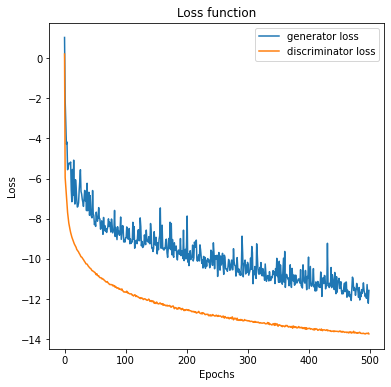

In [0]:
plt.figure(figsize=(6,6))
plt.plot(log(loss_generator))
plt.plot(log(loss_discriminator))
plt.title('Loss function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['generator loss','discriminator loss'])
plt.show()

## Evaluation

(1000, 3)


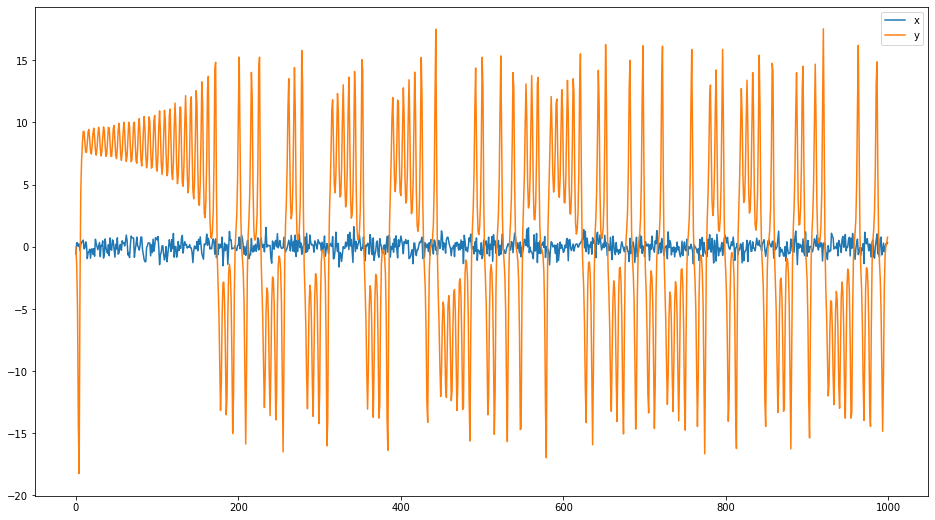

In [0]:
generated_data = g.generate(1)
generated_data = generated_data.reshape((int(np.shape(generated_data)[0]/3),3))
x_train = X_train[0,:].reshape((int(np.shape(X_train)[1]/3),3))
print(x_train.shape)
plt.plot(generated_data[:,0])
plt.plot(x_train[:,0])
#plt.plot(X_train[])
#plt.plot(generated_data[:,1])
#plt.plot(generated_data[:,2])
plt.legend(['x','y','z'])
plt.show()


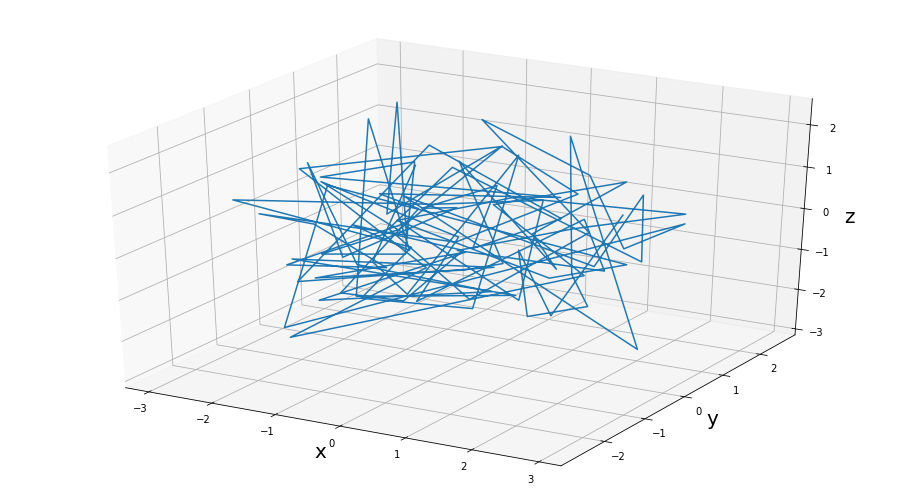

In [0]:
fig = figure()
ax = fig.gca(projection='3d')
ax.plot(generated_data[:,0], generated_data[:,1], generated_data[:,2])
ax.set_xlabel('x', size=20);ax.set_ylabel('y', size=20);ax.set_zlabel('z', size=20)
plt.show()

LSTM:



In [0]:
test_size = 0.3

train_test_limit = int((1-test_size)*X.shape[0])

X_train = X[0:train_test_limit,...]
X_test = X[train_test_limit:,...]
X_train.shape

(700, 3000)

In [0]:
class gan_LSTM(object): 
    def __init__(self):

        self.input_dim = 3000
        self.generator = Sequential() 
        self.discriminator = Sequential()
        self.gan = Model()
        
        self.create_generator()
        self.create_discriminator()
        self.create_gan()
    
    def create_generator(self):
        self.generator.add(LSTM(100, activation='tanh', recurrent_activation='sigmoid',input_shape=(1,self.input_dim)))
        self.generator.add(Dense(units=self.input_dim,activation ='tanh'))
        self.generator.compile(loss='binary_crossentropy', optimizer='adam')
        
    def create_discriminator(self):

        self.discriminator.add(BatchNormalization(input_shape=[self.input_dim]))

        
        self.discriminator.add(Dense(units=100, activation='selu'))

        #self.discriminator.add(Dense(units=512,activation ='selu'))
        #self.discriminator.add(LeakyReLU(alpha=0.2))

        self.discriminator.add(Dense(units=20,activation ='selu'))
        #self.discriminator.add(LeakyReLU(alpha=0.2))

        self.discriminator.add(Dense(units=1, activation='sigmoid'))

        self.discriminator.compile(loss='binary_crossentropy', optimizer='adam')

    def create_gan(self):
        
        self.discriminator.trainable=False
        gan_input = Input(shape=(1,self.input_dim,))
        x = self.generator(gan_input)
        gan_output= self.discriminator(x)
        self.gan = Model(inputs=gan_input, outputs=gan_output)
        self.gan.compile(loss='binary_crossentropy', optimizer='adam')
    
    def gan_summary(self):
        
        self.gan.summary()
        
    def generator_summary(self):
        
        self.generator.summary()

    def discriminator_summary(self):
        
        self.discriminator.summary()
        
    def train(self,X_train, epochs=1, batch_size=128):

        #Loading the data
        batch_count = int((X_train.shape[0] / batch_size))+1

        loss_list = []
        loss_list_discriminator = []
        for e in range(1,epochs+1 ):
            print("Epoch %d" %e)
            loss = 0
            loss_discriminator = 0
            idx = np.random.randint(0,X_train.shape[0],X_train.shape[0])

            for _ in tqdm(range(batch_count)):

                # Real trajectories
                real_trajectory = X_train[idx[batch_size*_:batch_size*_+batch_size,...]]

                N = np.shape(real_trajectory)[0]#we now use N instead of batch_size, as the last batch
                                                #may be smaller than the batch size
                if N == 0:
                  break

                #generate  random noise as an input  to  initialize the  generator
                noise= np.random.normal(0,1, [N,1 ,self.input_dim])

                generated_trajectory = np.array(self.generator.predict(noise))#.reshape(N,100,3)
                #Construct different batches of  real and fake data 

                X= np.concatenate([real_trajectory, generated_trajectory], axis=0)

                # Labels for generated and real data
                y_dis=np.zeros(2*N)
                y_dis[:N]= 1 #0.9bat

                #Pre train discriminator on  fake and real data  before starting the gan. 
                self.discriminator.trainable=True
                
                loss_discriminator = loss_discriminator + self.discriminator.train_on_batch(X, y_dis)


                #Tricking the noised input of the Generator as real data
                noise= np.random.normal(0,1, [N,1, self.input_dim])
                y_gen = np.ones(N)

                # During the training of gan, 
                # the weights of discriminator should be fixed. 
                #We can enforce that by setting the trainable flag
                self.discriminator.trainable=False

                #training  the GAN by alternating the training of the Discriminator 
                #and training the chained GAN model with Discriminator’s weights freezed.
                loss = loss + self.gan.train_on_batch(noise, y_gen)
            loss_list.append(loss)
            loss_list_discriminator.append(loss_discriminator)
        return loss_list, loss_list_discriminator
            #if e == 1 or e % 20 == 0:

                 #plot_generated_images(e, generator)
            
    def generate(self,N):

        noise= np.random.normal(0,1, [N,1, self.input_dim])

        return np.transpose(self.generator.predict(noise))

In [0]:
g_LSTM=gan_LSTM()
g_LSTM.generator_summary()
g_LSTM.discriminator_summary()
g_LSTM.gan_summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               1240400   
_________________________________________________________________
dense_9 (Dense)              (None, 3000)              303000    
Total params: 1,543,400
Trainable params: 1,543,400
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 3000)              12000     
_________________________________________________________________
dense_10 (Dense)             (None, 100)               300100    
_________________________________________________________________
dense_11 (Dense)             (None, 20)                2020      
_____________________

In [0]:
loss_generator,loss_discriminator = g_LSTM.train(X_train,500,128)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1


 33%|███▎      | 2/6 [00:00<00:00, 16.74it/s]

Epoch 2


 33%|███▎      | 2/6 [00:00<00:00, 15.69it/s]

Epoch 3


 33%|███▎      | 2/6 [00:00<00:00, 17.15it/s]

Epoch 4


 33%|███▎      | 2/6 [00:00<00:00, 17.05it/s]

Epoch 5


 33%|███▎      | 2/6 [00:00<00:00, 16.06it/s]

Epoch 6


 33%|███▎      | 2/6 [00:00<00:00, 16.92it/s]

Epoch 7


 33%|███▎      | 2/6 [00:00<00:00, 17.25it/s]

Epoch 8


 33%|███▎      | 2/6 [00:00<00:00, 17.21it/s]

Epoch 9


 33%|███▎      | 2/6 [00:00<00:00, 17.38it/s]

Epoch 10


 33%|███▎      | 2/6 [00:00<00:00, 15.68it/s]

Epoch 11


 33%|███▎      | 2/6 [00:00<00:00, 17.13it/s]

Epoch 12


 33%|███▎      | 2/6 [00:00<00:00, 16.46it/s]

Epoch 13


 33%|███▎      | 2/6 [00:00<00:00, 15.83it/s]

Epoch 14


 33%|███▎      | 2/6 [00:00<00:00, 17.79it/s]

Epoch 15


 33%|███▎      | 2/6 [00:00<00:00, 16.87it/s]

Epoch 16


 33%|███▎      | 2/6 [00:00<00:00, 16.22it/s]

Epoch 17


 33%|███▎      | 2/6 [00:00<00:00, 17.33it/s]

Epoch 18


 33%|███▎      | 2/6 [00:00<00:00, 16.99it/s]

Epoch 19


 33%|███▎      | 2/6 [00:00<00:00, 17.10it/s]

Epoch 20


 33%|███▎      | 2/6 [00:00<00:00, 17.19it/s]

Epoch 21


 33%|███▎      | 2/6 [00:00<00:00, 17.03it/s]

Epoch 22


 33%|███▎      | 2/6 [00:00<00:00, 17.26it/s]

Epoch 23


 33%|███▎      | 2/6 [00:00<00:00, 15.86it/s]

Epoch 24


 33%|███▎      | 2/6 [00:00<00:00, 15.02it/s]

Epoch 25


 33%|███▎      | 2/6 [00:00<00:00, 17.57it/s]

Epoch 26


 33%|███▎      | 2/6 [00:00<00:00, 16.26it/s]

Epoch 27


 33%|███▎      | 2/6 [00:00<00:00, 17.60it/s]

Epoch 28


 33%|███▎      | 2/6 [00:00<00:00, 17.26it/s]

Epoch 29


 33%|███▎      | 2/6 [00:00<00:00, 16.43it/s]

Epoch 30


 33%|███▎      | 2/6 [00:00<00:00, 17.82it/s]

Epoch 31


 33%|███▎      | 2/6 [00:00<00:00, 16.87it/s]

Epoch 32


 33%|███▎      | 2/6 [00:00<00:00, 16.72it/s]

Epoch 33


 33%|███▎      | 2/6 [00:00<00:00, 17.51it/s]

Epoch 34


 33%|███▎      | 2/6 [00:00<00:00, 16.96it/s]

Epoch 35


 33%|███▎      | 2/6 [00:00<00:00, 16.24it/s]

Epoch 36


 33%|███▎      | 2/6 [00:00<00:00, 16.78it/s]

Epoch 37


 33%|███▎      | 2/6 [00:00<00:00, 16.71it/s]

Epoch 38


 33%|███▎      | 2/6 [00:00<00:00, 17.41it/s]

Epoch 39


 33%|███▎      | 2/6 [00:00<00:00, 17.53it/s]

Epoch 40


 33%|███▎      | 2/6 [00:00<00:00, 16.70it/s]

Epoch 41


 33%|███▎      | 2/6 [00:00<00:00, 15.72it/s]

Epoch 42


 33%|███▎      | 2/6 [00:00<00:00, 15.59it/s]

Epoch 43


 33%|███▎      | 2/6 [00:00<00:00, 16.54it/s]

Epoch 44


 33%|███▎      | 2/6 [00:00<00:00, 17.14it/s]

Epoch 45


 33%|███▎      | 2/6 [00:00<00:00, 16.71it/s]

Epoch 46


 33%|███▎      | 2/6 [00:00<00:00, 16.65it/s]

Epoch 47


 33%|███▎      | 2/6 [00:00<00:00, 16.12it/s]

Epoch 48


 33%|███▎      | 2/6 [00:00<00:00, 15.44it/s]

Epoch 49


 33%|███▎      | 2/6 [00:00<00:00, 16.32it/s]

Epoch 50


 33%|███▎      | 2/6 [00:00<00:00, 17.16it/s]

Epoch 51


 33%|███▎      | 2/6 [00:00<00:00, 17.33it/s]

Epoch 52


 33%|███▎      | 2/6 [00:00<00:00, 17.28it/s]

Epoch 53


 33%|███▎      | 2/6 [00:00<00:00, 17.36it/s]

Epoch 54


 33%|███▎      | 2/6 [00:00<00:00, 17.69it/s]

Epoch 55


 33%|███▎      | 2/6 [00:00<00:00, 16.94it/s]

Epoch 56


 33%|███▎      | 2/6 [00:00<00:00, 16.61it/s]

Epoch 57


 33%|███▎      | 2/6 [00:00<00:00, 17.02it/s]

Epoch 58


 33%|███▎      | 2/6 [00:00<00:00, 16.94it/s]

Epoch 59


 33%|███▎      | 2/6 [00:00<00:00, 17.25it/s]

Epoch 60


 33%|███▎      | 2/6 [00:00<00:00, 17.79it/s]

Epoch 61


 33%|███▎      | 2/6 [00:00<00:00, 16.43it/s]

Epoch 62


 33%|███▎      | 2/6 [00:00<00:00, 17.43it/s]

Epoch 63


 33%|███▎      | 2/6 [00:00<00:00, 17.96it/s]

Epoch 64


 33%|███▎      | 2/6 [00:00<00:00, 16.25it/s]

Epoch 65


 33%|███▎      | 2/6 [00:00<00:00, 16.71it/s]

Epoch 66


 33%|███▎      | 2/6 [00:00<00:00, 16.60it/s]

Epoch 67


 33%|███▎      | 2/6 [00:00<00:00, 16.78it/s]

Epoch 68


 33%|███▎      | 2/6 [00:00<00:00, 15.34it/s]

Epoch 69


 33%|███▎      | 2/6 [00:00<00:00, 17.26it/s]

Epoch 70


 33%|███▎      | 2/6 [00:00<00:00, 16.67it/s]

Epoch 71


 33%|███▎      | 2/6 [00:00<00:00, 16.14it/s]

Epoch 72


 33%|███▎      | 2/6 [00:00<00:00, 17.90it/s]

Epoch 73


 33%|███▎      | 2/6 [00:00<00:00, 17.10it/s]

Epoch 74


 33%|███▎      | 2/6 [00:00<00:00, 16.83it/s]

Epoch 75


 33%|███▎      | 2/6 [00:00<00:00, 18.04it/s]

Epoch 76


 33%|███▎      | 2/6 [00:00<00:00, 17.41it/s]

Epoch 77


 33%|███▎      | 2/6 [00:00<00:00, 17.12it/s]

Epoch 78


 33%|███▎      | 2/6 [00:00<00:00, 17.73it/s]

Epoch 79


 33%|███▎      | 2/6 [00:00<00:00, 16.89it/s]

Epoch 80


 33%|███▎      | 2/6 [00:00<00:00, 17.15it/s]

Epoch 81


 33%|███▎      | 2/6 [00:00<00:00, 17.34it/s]

Epoch 82


 33%|███▎      | 2/6 [00:00<00:00, 17.11it/s]

Epoch 83


 33%|███▎      | 2/6 [00:00<00:00, 17.28it/s]

Epoch 84


 33%|███▎      | 2/6 [00:00<00:00, 17.02it/s]

Epoch 85


 33%|███▎      | 2/6 [00:00<00:00, 17.65it/s]

Epoch 86


 33%|███▎      | 2/6 [00:00<00:00, 16.72it/s]

Epoch 87


 33%|███▎      | 2/6 [00:00<00:00, 17.60it/s]

Epoch 88


 33%|███▎      | 2/6 [00:00<00:00, 17.80it/s]

Epoch 89


 33%|███▎      | 2/6 [00:00<00:00, 16.88it/s]

Epoch 90


 33%|███▎      | 2/6 [00:00<00:00, 17.52it/s]

Epoch 91


 33%|███▎      | 2/6 [00:00<00:00, 16.49it/s]

Epoch 92


 33%|███▎      | 2/6 [00:00<00:00, 15.68it/s]

Epoch 93


 33%|███▎      | 2/6 [00:00<00:00, 17.58it/s]

Epoch 94


 33%|███▎      | 2/6 [00:00<00:00, 15.67it/s]

Epoch 95


 33%|███▎      | 2/6 [00:00<00:00, 16.52it/s]

Epoch 96


 33%|███▎      | 2/6 [00:00<00:00, 17.43it/s]

Epoch 97


 33%|███▎      | 2/6 [00:00<00:00, 17.28it/s]

Epoch 98


 33%|███▎      | 2/6 [00:00<00:00, 15.55it/s]

Epoch 99


 33%|███▎      | 2/6 [00:00<00:00, 17.52it/s]

Epoch 100


 33%|███▎      | 2/6 [00:00<00:00, 17.25it/s]

Epoch 101


 33%|███▎      | 2/6 [00:00<00:00, 17.48it/s]

Epoch 102


 33%|███▎      | 2/6 [00:00<00:00, 16.37it/s]

Epoch 103


 33%|███▎      | 2/6 [00:00<00:00, 14.22it/s]

Epoch 104


 33%|███▎      | 2/6 [00:00<00:00, 15.14it/s]

Epoch 105


 33%|███▎      | 2/6 [00:00<00:00, 16.92it/s]

Epoch 106


 33%|███▎      | 2/6 [00:00<00:00, 17.04it/s]

Epoch 107


 33%|███▎      | 2/6 [00:00<00:00, 15.72it/s]

Epoch 108


 33%|███▎      | 2/6 [00:00<00:00, 15.33it/s]

Epoch 109


 33%|███▎      | 2/6 [00:00<00:00, 17.95it/s]

Epoch 110


 33%|███▎      | 2/6 [00:00<00:00, 17.04it/s]

Epoch 111


 33%|███▎      | 2/6 [00:00<00:00, 15.89it/s]

Epoch 112


 33%|███▎      | 2/6 [00:00<00:00, 17.35it/s]

Epoch 113


 33%|███▎      | 2/6 [00:00<00:00, 16.40it/s]

Epoch 114


 33%|███▎      | 2/6 [00:00<00:00, 16.39it/s]

Epoch 115


 33%|███▎      | 2/6 [00:00<00:00, 17.54it/s]

Epoch 116


 33%|███▎      | 2/6 [00:00<00:00, 16.91it/s]

Epoch 117


 33%|███▎      | 2/6 [00:00<00:00, 16.42it/s]

Epoch 118


 33%|███▎      | 2/6 [00:00<00:00, 16.75it/s]

Epoch 119


 33%|███▎      | 2/6 [00:00<00:00, 17.30it/s]

Epoch 120


 33%|███▎      | 2/6 [00:00<00:00, 16.75it/s]

Epoch 121


 33%|███▎      | 2/6 [00:00<00:00, 15.84it/s]

Epoch 122


 33%|███▎      | 2/6 [00:00<00:00, 16.88it/s]

Epoch 123


 33%|███▎      | 2/6 [00:00<00:00, 16.50it/s]

Epoch 124


 33%|███▎      | 2/6 [00:00<00:00, 17.84it/s]

Epoch 125


 33%|███▎      | 2/6 [00:00<00:00, 17.82it/s]

Epoch 126


 33%|███▎      | 2/6 [00:00<00:00, 16.60it/s]

Epoch 127


 33%|███▎      | 2/6 [00:00<00:00, 17.22it/s]

Epoch 128


 33%|███▎      | 2/6 [00:00<00:00, 17.40it/s]

Epoch 129


 33%|███▎      | 2/6 [00:00<00:00, 15.80it/s]

Epoch 130


 33%|███▎      | 2/6 [00:00<00:00, 17.46it/s]

Epoch 131


 33%|███▎      | 2/6 [00:00<00:00, 16.75it/s]

Epoch 132


 33%|███▎      | 2/6 [00:00<00:00, 16.11it/s]

Epoch 133


 33%|███▎      | 2/6 [00:00<00:00, 18.03it/s]

Epoch 134


 33%|███▎      | 2/6 [00:00<00:00, 17.95it/s]

Epoch 135


 33%|███▎      | 2/6 [00:00<00:00, 16.18it/s]

Epoch 136


 33%|███▎      | 2/6 [00:00<00:00, 17.24it/s]

Epoch 137


 33%|███▎      | 2/6 [00:00<00:00, 17.51it/s]

Epoch 138


 33%|███▎      | 2/6 [00:00<00:00, 16.03it/s]

Epoch 139


 33%|███▎      | 2/6 [00:00<00:00, 17.41it/s]

Epoch 140


 33%|███▎      | 2/6 [00:00<00:00, 17.05it/s]

Epoch 141


 33%|███▎      | 2/6 [00:00<00:00, 15.97it/s]

Epoch 142


 33%|███▎      | 2/6 [00:00<00:00, 17.63it/s]

Epoch 143


 33%|███▎      | 2/6 [00:00<00:00, 16.61it/s]

Epoch 144


 33%|███▎      | 2/6 [00:00<00:00, 15.62it/s]

Epoch 145


 33%|███▎      | 2/6 [00:00<00:00, 17.73it/s]

Epoch 146


 33%|███▎      | 2/6 [00:00<00:00, 17.34it/s]

Epoch 147


 33%|███▎      | 2/6 [00:00<00:00, 16.84it/s]

Epoch 148


 33%|███▎      | 2/6 [00:00<00:00, 16.24it/s]

Epoch 149


 33%|███▎      | 2/6 [00:00<00:00, 17.62it/s]

Epoch 150


 33%|███▎      | 2/6 [00:00<00:00, 16.50it/s]

Epoch 151


 33%|███▎      | 2/6 [00:00<00:00, 16.90it/s]

Epoch 152


 33%|███▎      | 2/6 [00:00<00:00, 17.60it/s]

Epoch 153


 33%|███▎      | 2/6 [00:00<00:00, 17.48it/s]

Epoch 154


 33%|███▎      | 2/6 [00:00<00:00, 18.10it/s]

Epoch 155


 33%|███▎      | 2/6 [00:00<00:00, 17.58it/s]

Epoch 156


 33%|███▎      | 2/6 [00:00<00:00, 17.26it/s]

Epoch 157


 33%|███▎      | 2/6 [00:00<00:00, 16.86it/s]

Epoch 158


 33%|███▎      | 2/6 [00:00<00:00, 16.98it/s]

Epoch 159


 33%|███▎      | 2/6 [00:00<00:00, 17.14it/s]

Epoch 160


 33%|███▎      | 2/6 [00:00<00:00, 17.17it/s]

Epoch 161


 33%|███▎      | 2/6 [00:00<00:00, 16.56it/s]

Epoch 162


 33%|███▎      | 2/6 [00:00<00:00, 15.82it/s]

Epoch 163


 33%|███▎      | 2/6 [00:00<00:00, 17.95it/s]

Epoch 164


 33%|███▎      | 2/6 [00:00<00:00, 16.60it/s]

Epoch 165


 33%|███▎      | 2/6 [00:00<00:00, 15.97it/s]

Epoch 166


 33%|███▎      | 2/6 [00:00<00:00, 16.24it/s]

Epoch 167


 33%|███▎      | 2/6 [00:00<00:00, 16.83it/s]

Epoch 168


 33%|███▎      | 2/6 [00:00<00:00, 16.84it/s]

Epoch 169


 33%|███▎      | 2/6 [00:00<00:00, 17.26it/s]

Epoch 170


 33%|███▎      | 2/6 [00:00<00:00, 17.79it/s]

Epoch 171


 33%|███▎      | 2/6 [00:00<00:00, 17.05it/s]

Epoch 172


 33%|███▎      | 2/6 [00:00<00:00, 16.92it/s]

Epoch 173


 33%|███▎      | 2/6 [00:00<00:00, 17.27it/s]

Epoch 174


 33%|███▎      | 2/6 [00:00<00:00, 17.41it/s]

Epoch 175


 33%|███▎      | 2/6 [00:00<00:00, 17.02it/s]

Epoch 176


 33%|███▎      | 2/6 [00:00<00:00, 17.98it/s]

Epoch 177


 33%|███▎      | 2/6 [00:00<00:00, 16.47it/s]

Epoch 178


 33%|███▎      | 2/6 [00:00<00:00, 17.54it/s]

Epoch 179


 33%|███▎      | 2/6 [00:00<00:00, 17.76it/s]

Epoch 180


 33%|███▎      | 2/6 [00:00<00:00, 16.29it/s]

Epoch 181


 33%|███▎      | 2/6 [00:00<00:00, 17.41it/s]

Epoch 182


 33%|███▎      | 2/6 [00:00<00:00, 16.65it/s]

Epoch 183


 33%|███▎      | 2/6 [00:00<00:00, 16.51it/s]

Epoch 184


 33%|███▎      | 2/6 [00:00<00:00, 18.04it/s]

Epoch 185


 33%|███▎      | 2/6 [00:00<00:00, 17.03it/s]

Epoch 186


 33%|███▎      | 2/6 [00:00<00:00, 17.32it/s]

Epoch 187


 33%|███▎      | 2/6 [00:00<00:00, 17.49it/s]

Epoch 188


 33%|███▎      | 2/6 [00:00<00:00, 18.08it/s]

Epoch 189


 33%|███▎      | 2/6 [00:00<00:00, 17.80it/s]

Epoch 190


 33%|███▎      | 2/6 [00:00<00:00, 17.81it/s]

Epoch 191


 33%|███▎      | 2/6 [00:00<00:00, 17.74it/s]

Epoch 192


 33%|███▎      | 2/6 [00:00<00:00, 16.48it/s]

Epoch 193


 33%|███▎      | 2/6 [00:00<00:00, 18.21it/s]

Epoch 194


 33%|███▎      | 2/6 [00:00<00:00, 17.54it/s]

Epoch 195


 33%|███▎      | 2/6 [00:00<00:00, 17.94it/s]

Epoch 196


 33%|███▎      | 2/6 [00:00<00:00, 17.39it/s]

Epoch 197


 33%|███▎      | 2/6 [00:00<00:00, 18.28it/s]

Epoch 198


 33%|███▎      | 2/6 [00:00<00:00, 14.95it/s]

Epoch 199


 33%|███▎      | 2/6 [00:00<00:00, 17.76it/s]

Epoch 200


 33%|███▎      | 2/6 [00:00<00:00, 17.25it/s]

Epoch 201


 33%|███▎      | 2/6 [00:00<00:00, 16.96it/s]

Epoch 202


 33%|███▎      | 2/6 [00:00<00:00, 17.52it/s]

Epoch 203


 33%|███▎      | 2/6 [00:00<00:00, 17.63it/s]

Epoch 204


 33%|███▎      | 2/6 [00:00<00:00, 17.25it/s]

Epoch 205


 33%|███▎      | 2/6 [00:00<00:00, 17.92it/s]

Epoch 206


 33%|███▎      | 2/6 [00:00<00:00, 18.18it/s]

Epoch 207


 33%|███▎      | 2/6 [00:00<00:00, 17.94it/s]

Epoch 208


 33%|███▎      | 2/6 [00:00<00:00, 17.62it/s]

Epoch 209


 33%|███▎      | 2/6 [00:00<00:00, 17.13it/s]

Epoch 210


 33%|███▎      | 2/6 [00:00<00:00, 17.56it/s]

Epoch 211


 33%|███▎      | 2/6 [00:00<00:00, 17.85it/s]

Epoch 212


 33%|███▎      | 2/6 [00:00<00:00, 17.94it/s]

Epoch 213


 33%|███▎      | 2/6 [00:00<00:00, 17.84it/s]

Epoch 214


 33%|███▎      | 2/6 [00:00<00:00, 17.81it/s]

Epoch 215


 33%|███▎      | 2/6 [00:00<00:00, 16.17it/s]

Epoch 216


 33%|███▎      | 2/6 [00:00<00:00, 18.12it/s]

Epoch 217


 33%|███▎      | 2/6 [00:00<00:00, 17.92it/s]

Epoch 218


 33%|███▎      | 2/6 [00:00<00:00, 17.11it/s]

Epoch 219


 33%|███▎      | 2/6 [00:00<00:00, 15.70it/s]

Epoch 220


 33%|███▎      | 2/6 [00:00<00:00, 18.55it/s]

Epoch 221


 33%|███▎      | 2/6 [00:00<00:00, 17.48it/s]

Epoch 222


 33%|███▎      | 2/6 [00:00<00:00, 18.10it/s]

Epoch 223


 33%|███▎      | 2/6 [00:00<00:00, 16.60it/s]

Epoch 224


 33%|███▎      | 2/6 [00:00<00:00, 17.07it/s]

Epoch 225


 33%|███▎      | 2/6 [00:00<00:00, 16.83it/s]

Epoch 226


 33%|███▎      | 2/6 [00:00<00:00, 16.92it/s]

Epoch 227


 33%|███▎      | 2/6 [00:00<00:00, 16.01it/s]

Epoch 228


 33%|███▎      | 2/6 [00:00<00:00, 16.13it/s]

Epoch 229


 33%|███▎      | 2/6 [00:00<00:00, 16.77it/s]

Epoch 230


 33%|███▎      | 2/6 [00:00<00:00, 16.67it/s]

Epoch 231


 33%|███▎      | 2/6 [00:00<00:00, 17.68it/s]

Epoch 232


 33%|███▎      | 2/6 [00:00<00:00, 16.36it/s]

Epoch 233


 33%|███▎      | 2/6 [00:00<00:00, 16.90it/s]

Epoch 234


 33%|███▎      | 2/6 [00:00<00:00, 17.26it/s]

Epoch 235


 33%|███▎      | 2/6 [00:00<00:00, 16.80it/s]

Epoch 236


 33%|███▎      | 2/6 [00:00<00:00, 16.22it/s]

Epoch 237


 33%|███▎      | 2/6 [00:00<00:00, 16.58it/s]

Epoch 238


 33%|███▎      | 2/6 [00:00<00:00, 15.65it/s]

Epoch 239


 33%|███▎      | 2/6 [00:00<00:00, 16.86it/s]

Epoch 240


 33%|███▎      | 2/6 [00:00<00:00, 16.64it/s]

Epoch 241


 33%|███▎      | 2/6 [00:00<00:00, 16.68it/s]

Epoch 242


 33%|███▎      | 2/6 [00:00<00:00, 17.63it/s]

Epoch 243


 33%|███▎      | 2/6 [00:00<00:00, 16.07it/s]

Epoch 244


 33%|███▎      | 2/6 [00:00<00:00, 15.77it/s]

Epoch 245


 33%|███▎      | 2/6 [00:00<00:00, 16.89it/s]

Epoch 246


 33%|███▎      | 2/6 [00:00<00:00, 16.81it/s]

Epoch 247


 33%|███▎      | 2/6 [00:00<00:00, 16.51it/s]

Epoch 248


 33%|███▎      | 2/6 [00:00<00:00, 17.76it/s]

Epoch 249


 33%|███▎      | 2/6 [00:00<00:00, 17.71it/s]

Epoch 250


 33%|███▎      | 2/6 [00:00<00:00, 17.22it/s]

Epoch 251


 33%|███▎      | 2/6 [00:00<00:00, 15.34it/s]

Epoch 252


 33%|███▎      | 2/6 [00:00<00:00, 17.18it/s]

Epoch 253


 33%|███▎      | 2/6 [00:00<00:00, 17.47it/s]

Epoch 254


 33%|███▎      | 2/6 [00:00<00:00, 16.32it/s]

Epoch 255


 33%|███▎      | 2/6 [00:00<00:00, 16.08it/s]

Epoch 256


 33%|███▎      | 2/6 [00:00<00:00, 17.03it/s]

Epoch 257


 33%|███▎      | 2/6 [00:00<00:00, 16.78it/s]

Epoch 258


 33%|███▎      | 2/6 [00:00<00:00, 16.92it/s]

Epoch 259


 33%|███▎      | 2/6 [00:00<00:00, 17.16it/s]

Epoch 260


 33%|███▎      | 2/6 [00:00<00:00, 16.33it/s]

Epoch 261


 33%|███▎      | 2/6 [00:00<00:00, 18.13it/s]

Epoch 262


 33%|███▎      | 2/6 [00:00<00:00, 17.12it/s]

Epoch 263


 33%|███▎      | 2/6 [00:00<00:00, 17.47it/s]

Epoch 264


 33%|███▎      | 2/6 [00:00<00:00, 17.38it/s]

Epoch 265


 33%|███▎      | 2/6 [00:00<00:00, 17.46it/s]

Epoch 266


 33%|███▎      | 2/6 [00:00<00:00, 18.13it/s]

Epoch 267


 33%|███▎      | 2/6 [00:00<00:00, 18.35it/s]

Epoch 268


 33%|███▎      | 2/6 [00:00<00:00, 17.27it/s]

Epoch 269


 33%|███▎      | 2/6 [00:00<00:00, 17.06it/s]

Epoch 270


 33%|███▎      | 2/6 [00:00<00:00, 18.16it/s]

Epoch 271


 33%|███▎      | 2/6 [00:00<00:00, 17.89it/s]

Epoch 272


 33%|███▎      | 2/6 [00:00<00:00, 17.25it/s]

Epoch 273


 33%|███▎      | 2/6 [00:00<00:00, 16.65it/s]

Epoch 274


 33%|███▎      | 2/6 [00:00<00:00, 18.41it/s]

Epoch 275


 33%|███▎      | 2/6 [00:00<00:00, 17.99it/s]

Epoch 276


 33%|███▎      | 2/6 [00:00<00:00, 17.69it/s]

Epoch 277


 33%|███▎      | 2/6 [00:00<00:00, 18.45it/s]

Epoch 278


 33%|███▎      | 2/6 [00:00<00:00, 18.37it/s]

Epoch 279


 33%|███▎      | 2/6 [00:00<00:00, 17.82it/s]

Epoch 280


 33%|███▎      | 2/6 [00:00<00:00, 18.36it/s]

Epoch 281


 33%|███▎      | 2/6 [00:00<00:00, 17.86it/s]

Epoch 282


 33%|███▎      | 2/6 [00:00<00:00, 16.63it/s]

Epoch 283


 33%|███▎      | 2/6 [00:00<00:00, 17.43it/s]

Epoch 284


 33%|███▎      | 2/6 [00:00<00:00, 18.37it/s]

Epoch 285


 33%|███▎      | 2/6 [00:00<00:00, 16.50it/s]

Epoch 286


 33%|███▎      | 2/6 [00:00<00:00, 18.40it/s]

Epoch 287


 33%|███▎      | 2/6 [00:00<00:00, 16.77it/s]

Epoch 288


 33%|███▎      | 2/6 [00:00<00:00, 18.01it/s]

Epoch 289


 33%|███▎      | 2/6 [00:00<00:00, 16.88it/s]

Epoch 290


 33%|███▎      | 2/6 [00:00<00:00, 17.16it/s]

Epoch 291


 33%|███▎      | 2/6 [00:00<00:00, 15.07it/s]

Epoch 292


 33%|███▎      | 2/6 [00:00<00:00, 17.81it/s]

Epoch 293


 33%|███▎      | 2/6 [00:00<00:00, 16.20it/s]

Epoch 294


 33%|███▎      | 2/6 [00:00<00:00, 17.37it/s]

Epoch 295


 33%|███▎      | 2/6 [00:00<00:00, 16.43it/s]

Epoch 296


 33%|███▎      | 2/6 [00:00<00:00, 16.51it/s]

Epoch 297


 33%|███▎      | 2/6 [00:00<00:00, 17.82it/s]

Epoch 298


 33%|███▎      | 2/6 [00:00<00:00, 17.96it/s]

Epoch 299


 33%|███▎      | 2/6 [00:00<00:00, 17.11it/s]

Epoch 300


 33%|███▎      | 2/6 [00:00<00:00, 17.91it/s]

Epoch 301


 33%|███▎      | 2/6 [00:00<00:00, 17.32it/s]

Epoch 302


 33%|███▎      | 2/6 [00:00<00:00, 17.18it/s]

Epoch 303


 33%|███▎      | 2/6 [00:00<00:00, 18.25it/s]

Epoch 304


 33%|███▎      | 2/6 [00:00<00:00, 18.13it/s]

Epoch 305


 33%|███▎      | 2/6 [00:00<00:00, 17.76it/s]

Epoch 306


 33%|███▎      | 2/6 [00:00<00:00, 17.92it/s]

Epoch 307


 33%|███▎      | 2/6 [00:00<00:00, 17.41it/s]

Epoch 308


 33%|███▎      | 2/6 [00:00<00:00, 17.59it/s]

Epoch 309


 33%|███▎      | 2/6 [00:00<00:00, 18.35it/s]

Epoch 310


 33%|███▎      | 2/6 [00:00<00:00, 17.71it/s]

Epoch 311


 33%|███▎      | 2/6 [00:00<00:00, 17.98it/s]

Epoch 312


 33%|███▎      | 2/6 [00:00<00:00, 18.96it/s]

Epoch 313


 33%|███▎      | 2/6 [00:00<00:00, 17.35it/s]

Epoch 314


 33%|███▎      | 2/6 [00:00<00:00, 16.67it/s]

Epoch 315


 33%|███▎      | 2/6 [00:00<00:00, 17.63it/s]

Epoch 316


 33%|███▎      | 2/6 [00:00<00:00, 18.52it/s]

Epoch 317


 33%|███▎      | 2/6 [00:00<00:00, 17.47it/s]

Epoch 318


 33%|███▎      | 2/6 [00:00<00:00, 15.33it/s]

Epoch 319


 33%|███▎      | 2/6 [00:00<00:00, 17.28it/s]

Epoch 320


 33%|███▎      | 2/6 [00:00<00:00, 17.22it/s]

Epoch 321


 33%|███▎      | 2/6 [00:00<00:00, 16.84it/s]

Epoch 322


 33%|███▎      | 2/6 [00:00<00:00, 17.46it/s]

Epoch 323


 33%|███▎      | 2/6 [00:00<00:00, 16.84it/s]

Epoch 324


 33%|███▎      | 2/6 [00:00<00:00, 17.30it/s]

Epoch 325


 33%|███▎      | 2/6 [00:00<00:00, 17.01it/s]

Epoch 326


 33%|███▎      | 2/6 [00:00<00:00, 17.47it/s]

Epoch 327


 33%|███▎      | 2/6 [00:00<00:00, 16.93it/s]

Epoch 328


 33%|███▎      | 2/6 [00:00<00:00, 16.17it/s]

Epoch 329


 33%|███▎      | 2/6 [00:00<00:00, 16.85it/s]

Epoch 330


 33%|███▎      | 2/6 [00:00<00:00, 15.88it/s]

Epoch 331


 33%|███▎      | 2/6 [00:00<00:00, 16.29it/s]

Epoch 332


 33%|███▎      | 2/6 [00:00<00:00, 17.38it/s]

Epoch 333


 33%|███▎      | 2/6 [00:00<00:00, 17.76it/s]

Epoch 334


 33%|███▎      | 2/6 [00:00<00:00, 17.83it/s]

Epoch 335


 33%|███▎      | 2/6 [00:00<00:00, 16.66it/s]

Epoch 336


 33%|███▎      | 2/6 [00:00<00:00, 15.61it/s]

Epoch 337


 33%|███▎      | 2/6 [00:00<00:00, 15.76it/s]

Epoch 338


 33%|███▎      | 2/6 [00:00<00:00, 15.07it/s]

Epoch 339


 33%|███▎      | 2/6 [00:00<00:00, 17.42it/s]

Epoch 340


 33%|███▎      | 2/6 [00:00<00:00, 17.44it/s]

Epoch 341


 33%|███▎      | 2/6 [00:00<00:00, 16.87it/s]

Epoch 342


 33%|███▎      | 2/6 [00:00<00:00, 16.24it/s]

Epoch 343


 33%|███▎      | 2/6 [00:00<00:00, 16.43it/s]

Epoch 344


 33%|███▎      | 2/6 [00:00<00:00, 16.59it/s]

Epoch 345


 33%|███▎      | 2/6 [00:00<00:00, 17.61it/s]

Epoch 346


 33%|███▎      | 2/6 [00:00<00:00, 15.78it/s]

Epoch 347


 33%|███▎      | 2/6 [00:00<00:00, 15.25it/s]

Epoch 348


 33%|███▎      | 2/6 [00:00<00:00, 16.81it/s]

Epoch 349


 33%|███▎      | 2/6 [00:00<00:00, 16.86it/s]

Epoch 350


 33%|███▎      | 2/6 [00:00<00:00, 17.05it/s]

Epoch 351


 33%|███▎      | 2/6 [00:00<00:00, 16.98it/s]

Epoch 352


 33%|███▎      | 2/6 [00:00<00:00, 17.24it/s]

Epoch 353


 33%|███▎      | 2/6 [00:00<00:00, 17.32it/s]

Epoch 354


 33%|███▎      | 2/6 [00:00<00:00, 18.06it/s]

Epoch 355


 33%|███▎      | 2/6 [00:00<00:00, 17.53it/s]

Epoch 356


 33%|███▎      | 2/6 [00:00<00:00, 17.63it/s]

Epoch 357


 33%|███▎      | 2/6 [00:00<00:00, 17.42it/s]

Epoch 358


 33%|███▎      | 2/6 [00:00<00:00, 17.24it/s]

Epoch 359


 33%|███▎      | 2/6 [00:00<00:00, 16.49it/s]

Epoch 360


 33%|███▎      | 2/6 [00:00<00:00, 16.43it/s]

Epoch 361


 33%|███▎      | 2/6 [00:00<00:00, 17.41it/s]

Epoch 362


 33%|███▎      | 2/6 [00:00<00:00, 17.50it/s]

Epoch 363


 33%|███▎      | 2/6 [00:00<00:00, 18.07it/s]

Epoch 364


 33%|███▎      | 2/6 [00:00<00:00, 17.73it/s]

Epoch 365


 33%|███▎      | 2/6 [00:00<00:00, 16.87it/s]

Epoch 366


 33%|███▎      | 2/6 [00:00<00:00, 18.18it/s]

Epoch 367


 33%|███▎      | 2/6 [00:00<00:00, 18.14it/s]

Epoch 368


 33%|███▎      | 2/6 [00:00<00:00, 16.73it/s]

Epoch 369


 33%|███▎      | 2/6 [00:00<00:00, 17.33it/s]

Epoch 370


 33%|███▎      | 2/6 [00:00<00:00, 17.63it/s]

Epoch 371


 33%|███▎      | 2/6 [00:00<00:00, 18.12it/s]

Epoch 372


 33%|███▎      | 2/6 [00:00<00:00, 17.57it/s]

Epoch 373


 33%|███▎      | 2/6 [00:00<00:00, 16.30it/s]

Epoch 374


 33%|███▎      | 2/6 [00:00<00:00, 18.16it/s]

Epoch 375


 33%|███▎      | 2/6 [00:00<00:00, 17.37it/s]

Epoch 376


 33%|███▎      | 2/6 [00:00<00:00, 17.19it/s]

Epoch 377


 33%|███▎      | 2/6 [00:00<00:00, 16.34it/s]

Epoch 378


 33%|███▎      | 2/6 [00:00<00:00, 17.73it/s]

Epoch 379


 33%|███▎      | 2/6 [00:00<00:00, 17.32it/s]

Epoch 380


 33%|███▎      | 2/6 [00:00<00:00, 17.82it/s]

Epoch 381


 33%|███▎      | 2/6 [00:00<00:00, 16.42it/s]

Epoch 382


 33%|███▎      | 2/6 [00:00<00:00, 16.14it/s]

Epoch 383


 33%|███▎      | 2/6 [00:00<00:00, 16.80it/s]

Epoch 384


 33%|███▎      | 2/6 [00:00<00:00, 16.96it/s]

Epoch 385


 33%|███▎      | 2/6 [00:00<00:00, 17.53it/s]

Epoch 386


 33%|███▎      | 2/6 [00:00<00:00, 17.30it/s]

Epoch 387


 33%|███▎      | 2/6 [00:00<00:00, 16.30it/s]

Epoch 388


 33%|███▎      | 2/6 [00:00<00:00, 18.18it/s]

Epoch 389


 33%|███▎      | 2/6 [00:00<00:00, 17.88it/s]

Epoch 390


 33%|███▎      | 2/6 [00:00<00:00, 16.42it/s]

Epoch 391


 33%|███▎      | 2/6 [00:00<00:00, 15.10it/s]

Epoch 392


 33%|███▎      | 2/6 [00:00<00:00, 16.51it/s]

Epoch 393


 33%|███▎      | 2/6 [00:00<00:00, 17.07it/s]

Epoch 394


 33%|███▎      | 2/6 [00:00<00:00, 18.33it/s]

Epoch 395


 33%|███▎      | 2/6 [00:00<00:00, 17.05it/s]

Epoch 396


 33%|███▎      | 2/6 [00:00<00:00, 17.04it/s]

Epoch 397


 33%|███▎      | 2/6 [00:00<00:00, 17.93it/s]

Epoch 398


 33%|███▎      | 2/6 [00:00<00:00, 16.33it/s]

Epoch 399


 33%|███▎      | 2/6 [00:00<00:00, 16.34it/s]

Epoch 400


 33%|███▎      | 2/6 [00:00<00:00, 18.12it/s]

Epoch 401


 33%|███▎      | 2/6 [00:00<00:00, 17.66it/s]

Epoch 402


 33%|███▎      | 2/6 [00:00<00:00, 16.74it/s]

Epoch 403


 33%|███▎      | 2/6 [00:00<00:00, 18.23it/s]

Epoch 404


 33%|███▎      | 2/6 [00:00<00:00, 15.83it/s]

Epoch 405


 33%|███▎      | 2/6 [00:00<00:00, 17.19it/s]

Epoch 406


 33%|███▎      | 2/6 [00:00<00:00, 18.26it/s]

Epoch 407


 33%|███▎      | 2/6 [00:00<00:00, 17.20it/s]

Epoch 408


 33%|███▎      | 2/6 [00:00<00:00, 18.28it/s]

Epoch 409


 33%|███▎      | 2/6 [00:00<00:00, 18.56it/s]

Epoch 410


 33%|███▎      | 2/6 [00:00<00:00, 17.85it/s]

Epoch 411


 33%|███▎      | 2/6 [00:00<00:00, 17.42it/s]

Epoch 412


 33%|███▎      | 2/6 [00:00<00:00, 17.88it/s]

Epoch 413


 33%|███▎      | 2/6 [00:00<00:00, 17.42it/s]

Epoch 414


 33%|███▎      | 2/6 [00:00<00:00, 17.38it/s]

Epoch 415


 33%|███▎      | 2/6 [00:00<00:00, 17.56it/s]

Epoch 416


 33%|███▎      | 2/6 [00:00<00:00, 16.64it/s]

Epoch 417


 33%|███▎      | 2/6 [00:00<00:00, 17.72it/s]

Epoch 418


 33%|███▎      | 2/6 [00:00<00:00, 17.37it/s]

Epoch 419


 33%|███▎      | 2/6 [00:00<00:00, 16.32it/s]

Epoch 420


 33%|███▎      | 2/6 [00:00<00:00, 15.10it/s]

Epoch 421


 33%|███▎      | 2/6 [00:00<00:00, 18.05it/s]

Epoch 422


 33%|███▎      | 2/6 [00:00<00:00, 18.18it/s]

Epoch 423


 33%|███▎      | 2/6 [00:00<00:00, 17.68it/s]

Epoch 424


 33%|███▎      | 2/6 [00:00<00:00, 17.82it/s]

Epoch 425


 33%|███▎      | 2/6 [00:00<00:00, 16.83it/s]

Epoch 426


 33%|███▎      | 2/6 [00:00<00:00, 17.80it/s]

Epoch 427


 33%|███▎      | 2/6 [00:00<00:00, 18.17it/s]

Epoch 428


 33%|███▎      | 2/6 [00:00<00:00, 17.23it/s]

Epoch 429


 33%|███▎      | 2/6 [00:00<00:00, 18.05it/s]

Epoch 430


 33%|███▎      | 2/6 [00:00<00:00, 17.92it/s]

Epoch 431


 33%|███▎      | 2/6 [00:00<00:00, 17.77it/s]

Epoch 432


 33%|███▎      | 2/6 [00:00<00:00, 16.00it/s]

Epoch 433


 33%|███▎      | 2/6 [00:00<00:00, 17.84it/s]

Epoch 434


 33%|███▎      | 2/6 [00:00<00:00, 18.23it/s]

Epoch 435


 33%|███▎      | 2/6 [00:00<00:00, 17.15it/s]

Epoch 436


 33%|███▎      | 2/6 [00:00<00:00, 16.78it/s]

Epoch 437


 33%|███▎      | 2/6 [00:00<00:00, 17.64it/s]

Epoch 438


 33%|███▎      | 2/6 [00:00<00:00, 16.36it/s]

Epoch 439


 33%|███▎      | 2/6 [00:00<00:00, 18.17it/s]

Epoch 440


 33%|███▎      | 2/6 [00:00<00:00, 17.96it/s]

Epoch 441


 33%|███▎      | 2/6 [00:00<00:00, 17.96it/s]

Epoch 442


 33%|███▎      | 2/6 [00:00<00:00, 17.66it/s]

Epoch 443


 33%|███▎      | 2/6 [00:00<00:00, 15.94it/s]

Epoch 444


 33%|███▎      | 2/6 [00:00<00:00, 17.15it/s]

Epoch 445


 33%|███▎      | 2/6 [00:00<00:00, 18.01it/s]

Epoch 446


 33%|███▎      | 2/6 [00:00<00:00, 17.19it/s]

Epoch 447


 33%|███▎      | 2/6 [00:00<00:00, 15.80it/s]

Epoch 448


 33%|███▎      | 2/6 [00:00<00:00, 17.03it/s]

Epoch 449


 33%|███▎      | 2/6 [00:00<00:00, 16.55it/s]

Epoch 450


 33%|███▎      | 2/6 [00:00<00:00, 14.90it/s]

Epoch 451


 33%|███▎      | 2/6 [00:00<00:00, 17.95it/s]

Epoch 452


 33%|███▎      | 2/6 [00:00<00:00, 17.52it/s]

Epoch 453


 33%|███▎      | 2/6 [00:00<00:00, 16.65it/s]

Epoch 454


 33%|███▎      | 2/6 [00:00<00:00, 17.89it/s]

Epoch 455


 33%|███▎      | 2/6 [00:00<00:00, 17.02it/s]

Epoch 456


 33%|███▎      | 2/6 [00:00<00:00, 17.74it/s]

Epoch 457


 33%|███▎      | 2/6 [00:00<00:00, 17.70it/s]

Epoch 458


 33%|███▎      | 2/6 [00:00<00:00, 17.23it/s]

Epoch 459


 33%|███▎      | 2/6 [00:00<00:00, 15.54it/s]

Epoch 460


 33%|███▎      | 2/6 [00:00<00:00, 18.34it/s]

Epoch 461


 33%|███▎      | 2/6 [00:00<00:00, 16.40it/s]

Epoch 462


 33%|███▎      | 2/6 [00:00<00:00, 15.68it/s]

Epoch 463


 33%|███▎      | 2/6 [00:00<00:00, 17.46it/s]

Epoch 464


 33%|███▎      | 2/6 [00:00<00:00, 16.49it/s]

Epoch 465


 33%|███▎      | 2/6 [00:00<00:00, 17.13it/s]

Epoch 466


 33%|███▎      | 2/6 [00:00<00:00, 17.54it/s]

Epoch 467


 33%|███▎      | 2/6 [00:00<00:00, 17.60it/s]

Epoch 468


 33%|███▎      | 2/6 [00:00<00:00, 17.19it/s]

Epoch 469


 33%|███▎      | 2/6 [00:00<00:00, 16.58it/s]

Epoch 470


 33%|███▎      | 2/6 [00:00<00:00, 15.83it/s]

Epoch 471


 33%|███▎      | 2/6 [00:00<00:00, 16.35it/s]

Epoch 472


 33%|███▎      | 2/6 [00:00<00:00, 17.44it/s]

Epoch 473


 33%|███▎      | 2/6 [00:00<00:00, 18.09it/s]

Epoch 474


 33%|███▎      | 2/6 [00:00<00:00, 17.28it/s]

Epoch 475


 33%|███▎      | 2/6 [00:00<00:00, 17.56it/s]

Epoch 476


 33%|███▎      | 2/6 [00:00<00:00, 17.71it/s]

Epoch 477


 33%|███▎      | 2/6 [00:00<00:00, 17.38it/s]

Epoch 478


 33%|███▎      | 2/6 [00:00<00:00, 17.40it/s]

Epoch 479


 33%|███▎      | 2/6 [00:00<00:00, 16.70it/s]

Epoch 480


 33%|███▎      | 2/6 [00:00<00:00, 17.74it/s]

Epoch 481


 33%|███▎      | 2/6 [00:00<00:00, 18.31it/s]

Epoch 482


 33%|███▎      | 2/6 [00:00<00:00, 17.28it/s]

Epoch 483


 33%|███▎      | 2/6 [00:00<00:00, 16.69it/s]

Epoch 484


 33%|███▎      | 2/6 [00:00<00:00, 16.22it/s]

Epoch 485


 33%|███▎      | 2/6 [00:00<00:00, 17.02it/s]

Epoch 486


 33%|███▎      | 2/6 [00:00<00:00, 16.67it/s]

Epoch 487


 33%|███▎      | 2/6 [00:00<00:00, 15.66it/s]

Epoch 488


 33%|███▎      | 2/6 [00:00<00:00, 17.79it/s]

Epoch 489


 33%|███▎      | 2/6 [00:00<00:00, 17.82it/s]

Epoch 490


 33%|███▎      | 2/6 [00:00<00:00, 17.62it/s]

Epoch 491


 33%|███▎      | 2/6 [00:00<00:00, 17.04it/s]

Epoch 492


 33%|███▎      | 2/6 [00:00<00:00, 18.30it/s]

Epoch 493


 33%|███▎      | 2/6 [00:00<00:00, 17.13it/s]

Epoch 494


 33%|███▎      | 2/6 [00:00<00:00, 18.19it/s]

Epoch 495


 33%|███▎      | 2/6 [00:00<00:00, 18.46it/s]

Epoch 496


 33%|███▎      | 2/6 [00:00<00:00, 15.64it/s]

Epoch 497


 33%|███▎      | 2/6 [00:00<00:00, 16.82it/s]

Epoch 498


 33%|███▎      | 2/6 [00:00<00:00, 18.38it/s]

Epoch 499


 33%|███▎      | 2/6 [00:00<00:00, 16.26it/s]

Epoch 500


100%|██████████| 6/6 [00:00<00:00, 18.01it/s]


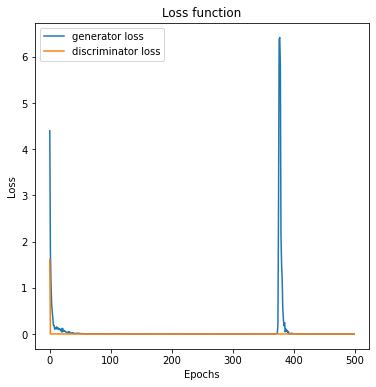

In [0]:
plt.figure(figsize=(6,6))
plt.plot(loss_generator)
plt.plot(loss_discriminator)
plt.title('Loss function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['generator loss','discriminator loss'])
plt.show()

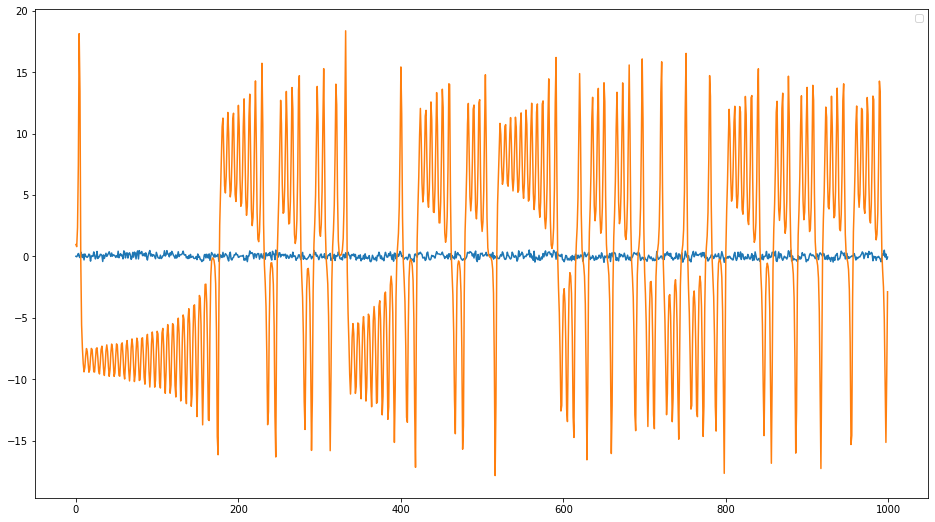

In [0]:
generated_data = g_LSTM.generate(1)
generated_data = generated_data.reshape((int(np.shape(generated_data)[0]/3),3))
x_train = X_train[0,:].reshape((int(np.shape(X_train)[1]/3),3))
plt.plot(generated_data[:,0])
plt.plot(x_train[:,0])
plt.legend('Real','Fake')
#plt.plot(generated_data[:,1])
#plt.plot(generated_data[:,2])
plt.show()

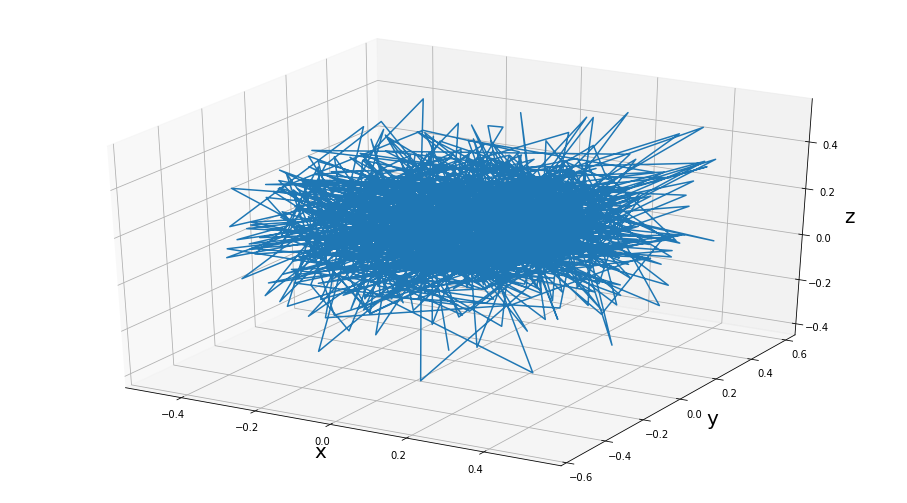

In [0]:
fig = figure()
ax = fig.gca(projection='3d')
ax.plot(generated_data[:,0], generated_data[:,1], generated_data[:,2])
ax.set_xlabel('x', size=20);ax.set_ylabel('y', size=20);ax.set_zlabel('z', size=20)
plt.show()

CNN

In [0]:
def generate_data_as_images(N,l=100,T=1, dt = 0.001):
    
    #Model parameters
    #dt = 0.001 # integration time step
    sigma = 10
    rho = 28
    beta = 8/3
    #l = int((T-dt)/dt)
    
    #T = dt*(l+1)
    #dt = T/(l+1)
    
    #X = np.zeros((N,3*(l-9)))
    X = []
    for n in range(N):    

        x0 = [np.random.randn(), np.random.randn(), np.random.randn()]

        # generate the Lorenz-63 system
        x = odeint(Lorenz_63, x0, arange(0.01,T,dt), args=(sigma, rho, beta))
        #X[n,...] = np.ndarray.flatten(x)
        #X.append(np.ndarray.flatten(x))
        X.append(x)
    return np.array(X)

In [0]:
N = 10
X = generate_data_as_images(N,T=100, dt=0.1)

X_train, X_test = train_test_split(X, test_size=0.33, random_state=42)
X.shape

(10, 1000, 3)

In [0]:
class gan_CNN(object): 

    def __init__(self):

        self.noise_dim = 3000
        self.img_cols = 1000
        self.img_rows = 3
        self.channels = 1

        self.generator = Sequential() 
        self.discriminator = Sequential()
        self.gan = Model()
        
        self.create_generator()
        self.create_discriminator()
        self.create_gan()

    def create_generator():
        
        # Starting size
        d = 4
        self.generator.add(Dense(d*d*256, kernel_initializer=RandomNormal(0, 0.02), input_dim=noise_dim))
        self.generator.add(LeakyReLU(0.2))
        # 4x4x256
        self.generator.add(Reshape((d, d, 256)))
        
        # 8x8x128
        self.generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
        self.generator.add(LeakyReLU(0.2))
        
        # 16x16*128
        self.generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
        self.generator.add(LeakyReLU(0.2))
        
        # 32x32x128
        self.generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
        self.generator.add(LeakyReLU(0.2))
        
        # 32x32x3
        self.generator.add(Conv2D(channels, (3, 3), padding='same', activation='tanh', kernel_initializer=RandomNormal(0, 0.02)))
        # activation should be linear
        
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
      
    def create_descriminator():

        self.discriminator.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(self.img_cols, self.img_rows, self.channels)))
        self.discriminator.add(LeakyReLU(0.2))

        self.discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
        self.discriminator.add(LeakyReLU(0.2))

        self.discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
        self.discriminator.add(LeakyReLU(0.2))

        self.discriminator.add(Conv2D(256, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
        self.discriminator.add(LeakyReLU(0.2))

        self.discriminator.add(Flatten())
        self.discriminator.add(Dropout(0.4))
        self.discriminator.add(Dense(1, activation='sigmoid', input_shape=(self.img_cols, self.img_rows, self.channels)))

        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

    def create_gan(self):

        # Make the discriminator untrainable when we are training the generator.  This doesn't effect the discriminator by itself
        discriminator.trainable = False

        # Link the two models to create the GAN
        gan_input = Input(shape=(self.noise_dim,))
        fake_image = self.generator(gan_input)

        gan_output = self.discriminator(fake_image)

        self.gan = Model(gan_input, gan_output)
        self.gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    def gan_summary(self):
        
        self.gan.summary()
        
    def generator_summary(self):
        
        self.generator.summary()

    def discriminator_summary(self):
        
        self.discriminator.summary()
        
    def train(self,X_train, epochs=1, batch_size=128):

        #Loading the data
        batch_count = int((X_train.shape[0] / batch_size))+1

        loss_list_generator = []
        loss_list_discriminator = []
        for e in range(1,epochs+1 ):
            print("Epoch %d" %e)
            loss_generator = 0
            loss_discriminator = 0
            idx = np.random.randint(0,X_train.shape[0],X_train.shape[0])

            for _ in tqdm(range(batch_count)):

                # Real trajectories
                real_trajectory = X_train[idx[batch_size*_:batch_size*_+batch_size,...]]

                N = np.shape(real_trajectory)[0]#we now use N instead of batch_size, as the last batch
                                                #may be smaller than the batch size

                #generate  random noise as an input  to  initialize the  generator
                noise= np.random.normal(0,1, [N, self.input_dim])

                generated_trajectory = self.generator.predict(noise)#.reshape(N,100,3)

                #Construct different batches of  real and fake data 
                X= np.concatenate([real_trajectory, generated_trajectory], axis=0)

                # Labels for generated and real data
                y_dis=np.zeros(2*N)
                y_dis[:N]= 1 #0.9bat

                #Pre train discriminator on  fake and real data  before starting the gan. 
                self.discriminator.trainable=True
                
                loss_discriminator = loss_discriminator + self.discriminator.train_on_batch(X, y_dis)


                #Tricking the noised input of the Generator as real data
                noise= np.random.normal(0,1, [N, self.input_dim])
                y_gen = np.ones(N)

                # During the training of gan, 
                # the weights of discriminator should be fixed. 
                #We can enforce that by setting the trainable flag
                self.discriminator.trainable=False

                #training  the GAN by alternating the training of the Discriminator 
                #and training the chained GAN model with Discriminator’s weights freezed.
                loss_generator = loss_generator + self.gan.train_on_batch(noise, y_gen)
            loss_list_generator.append(loss_generator)
            loss_list_discriminator.append(loss_discriminator)
        return loss_list_generator, loss_list_discriminator
            #if e == 1 or e % 20 == 0:

                 #plot_generated_images(e, generator)
            
    def generate(self,N):

        noise= np.random.normal(0,1, [N, self.input_dim])

        return np.transpose(self.generator.predict(noise))
        

In [0]:
g_CNN=gan_CNN()
g_CNN.generator_summary()
g_CNN.discriminator_summary()
g_CNN.gan_summary()

RuntimeError: ignored